<a href="https://colab.research.google.com/github/leejunho12316/HonGongMachine/blob/main/Chapter11_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. 환경설정, 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from datetime import datetime, timedelta

np.random.seed(2025)

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [ ]:
train_termination = pd.read_csv('bidet_w_disp_termination_train.csv')
test_termination = pd.read_csv('bidet_w_disp_termination_test.csv')
train_voc = pd.read_csv('bidet_w_disp_voc_train.csv')
test_voc = pd.read_csv('bidet_w_disp_voc_test.csv')

In [ ]:
train_termination.head(5)

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.000,40393,43560,R09,R12
1,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.000,34460,0,_,R06
2,E1000003,N,20170731,1,1.0,10001,M,Y,N,Y,Y,Y,_,_,_,_,N,90000.000,0,28600,0,_
3,E1000004,Y,20090930,4,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,218303.001,34747,55000,P36,R11
4,E1000005,N,20151121,1,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,310095.999,59856,54082,R27,R22


In [ ]:
train_voc.head(5)

,id,voc_type_cd,voc_type_nm,voc_cnt,day_cnt
0,E1000001,6,청구 수/미납,1,1
1,E1000002,9,해지,1,1
2,E1000003,12,업무협조,1,1
3,E1000004,7,AS,1,1
4,E1000004,8,품질,1,1


In [ ]:
train_termination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            54990 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

#전처리 - 1. 데이터 합치기

In [ ]:
#termination, voc 데이터 합치기
train_voc_cnt = train_voc.pivot_table(values='voc_cnt', aggfunc='sum', index='id', columns='voc_type_nm',fill_value=0)
train_day_cnt = train_voc.pivot_table(values='day_cnt', aggfunc='sum', index='id', columns='voc_type_nm',fill_value=0)
test_voc_cnt = test_voc.pivot_table(values='voc_cnt', aggfunc='sum', index='id', columns='voc_type_nm', fill_value=0)
test_day_cnt = test_voc.pivot_table(values='day_cnt', aggfunc='sum', index='id', columns='voc_type_nm', fill_value=0)

In [ ]:
train_voc_cnt.head(3)

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
id,,,,,,,,,,,,,
E1000001,0,0,0,0,0,0,0,0,0,1,0,0,0
E1000002,0,0,0,0,0,0,0,0,0,0,0,1,0
E1000003,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
train_day_cnt.head(3)

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
id,,,,,,,,,,,,,
E1000001,0,0,0,0,0,0,0,0,0,1,0,0,0
E1000002,0,0,0,0,0,0,0,0,0,0,0,1,0
E1000003,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
#잘 됐는지 확인
print(train_voc_cnt.sum().sum(), train_voc['voc_cnt'].sum())
print(train_day_cnt.sum().sum(), train_voc['day_cnt'].sum())
print(test_voc_cnt.sum().sum(), test_voc['voc_cnt'].sum())
print(test_day_cnt.sum().sum(), test_voc['day_cnt'].sum())

90752 90752
82858 82858
8469 8469
7702 7702


In [ ]:
train_termination

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.000,40393,43560,R09,R12
1,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.000,34460,0,_,R06
2,E1000003,N,20170731,1,1.0,10001,M,Y,N,Y,Y,Y,_,_,_,_,N,90000.000,0,28600,0,_
3,E1000004,Y,20090930,4,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,218303.001,34747,55000,P36,R11
4,E1000005,N,20151121,1,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,310095.999,59856,54082,R27,R22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,E1054996,N,20050916,0,1.0,10001,M,Y,N,Y,N,Y,_,_,_,_,Y,127844.001,0,44800,P32,_
54996,E1054997,Y,20130117,0,1.0,10001,F,Y,N,Y,N,Y,R37,_,_,10291,N,99000.000,0,48400,P01,_
54997,E1054998,Y,20190709,4,1.0,10001,F,N,Y,N,N,N,_,_,_,_,N,77882.001,14759,0,_,R18
54998,E1054999,Y,20190812,3,1.0,10001,M,N,Y,N,N,N,_,_,_,_,N,114221.001,15031,0,_,R19


In [ ]:
#인덱스 초기화
train_voc_cnt = train_voc_cnt.reset_index(drop=True)
train_day_cnt = train_day_cnt.reset_index(drop=True)
test_voc_cnt = test_voc_cnt.reset_index(drop=True)
test_day_cnt = test_day_cnt.reset_index(drop=True)

In [ ]:
#칼럼명 prefix 추가
for col in train_voc_cnt.columns:
  train_voc_cnt.rename(columns = {col:'voc_cnt_'+col}, inplace=True)
  train_day_cnt.rename(columns = {col:'day_cnt_'+col}, inplace=True)
for col in test_voc_cnt.columns:
  test_voc_cnt.rename(columns = {col : 'voc_cnt_'+col}, inplace=True)
  test_day_cnt.rename(columns = {col : 'day_cnt_'+col}, inplace=True)


In [ ]:
test_day_cnt.head(3)

voc_type_nm,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,2,1,0,0,1,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0


In [ ]:
#합치기
train_data = pd.concat([train_termination, train_voc_cnt, train_day_cnt], axis=1)
test_data = pd.concat([test_termination, test_voc_cnt, test_day_cnt], axis=1)
print(train_data.shape, test_data.shape)

(55000, 48) (5000, 46)


In [ ]:
print([col for col in train_data.columns if col not in test_data.columns])
train_data.drop(['voc_cnt_대리점문의', 'day_cnt_대리점문의'], axis=1, inplace=True)
#train_data.drop([drop_cols], axis=1, inplace=True)

['voc_cnt_대리점문의', 'day_cnt_대리점문의']


In [ ]:
print(train_data.shape, test_data.shape)

(55000, 46) (5000, 46)


#전처리 - 2.결측치 처리

In [ ]:
#train_termination - w_disp_cnt 결측치
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(np.int64(10), np.int64(0))

In [ ]:
print(train_data['w_disp_cnt'].mean())
print(train_data['w_disp_cnt'].median())
train_data['w_disp_cnt'].mode()

0.7372067648663393
1.0


,w_disp_cnt
0,1.0


In [ ]:
train_data['w_disp_cnt'].fillna(train_data['w_disp_cnt'].median(), inplace=True)
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(np.int64(0), np.int64(0))

#전처리 - 3.데이터 유형

In [ ]:
train_data.info()
#new_data -> datetime
def GetDateTime(date):
  date = datetime.strptime(str(date), '%Y%m%d')
  return date

train_data['new_date'] = train_data['new_date'].map(lambda x: GetDateTime(x))
test_data['new_date'] = test_data['new_date'].map(lambda x : GetDateTime(x))


#cust_cd = object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            55000 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

In [ ]:
print("바뀐 type : ", train_data['new_date'].dtype, test_data['new_date'].dtype)

바뀐 type :  datetime64[ns] datetime64[ns]


In [ ]:
train_data['cust_cd'] = train_data['cust_cd'].astype('O')
test_data['cust_cd'] = test_data['cust_cd'].astype('O')
print('cust_cd :', train_data['cust_cd'].dtype)

cust_cd : object


#전처리 - 4. 파생 변수 추가하기

In [ ]:
#@title train/test new_date 시간 격차 삭제
train_data['new_date'].max(), test_data['new_date'].max()

(Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-30 00:00:00'))

In [ ]:
train_data['join_period'] = (datetime(2020,8,31) - train_data['new_date']).dt.days
test_data['join_period'] = (datetime(2020,9,30) - test_data['new_date']).dt.days

In [ ]:
train_data['join_period'].head(5)

,join_period
0,1228
1,2463
2,1127
3,3988
4,1745


In [ ]:
#@title 해지 경과 기간 코드
train_data['w_disp_trmn_eperd_cd'][train_data['w_disp_trmn_eperd_cd'] != '_']

,w_disp_trmn_eperd_cd
31,R37
38,R37
41,0
89,R37
94,R18
...,...
54930,R25
54939,R19
54951,R04
54959,R11


In [ ]:
train_data['bidet_trmn_eperd_cd'][train_data['bidet_trmn_eperd_cd'] != '_']

,bidet_trmn_eperd_cd
10,R37
12,R05
60,R02
74,R02
76,R08
...,...
54924,0
54929,R35
54964,R37
54980,R04


In [ ]:
train_data['w_disp_trmn_eperd_cd'].value_counts()

,count
w_disp_trmn_eperd_cd,
_,51578
R37,1161
0,462
R01,120
R02,86
R06,85
R05,82
R04,78
R03,69


In [ ]:
def Rcdtoint(Rcd):
  if Rcd=='_':
    return 38
  elif Rcd=='0':
    return 0
  else:
    return int(Rcd[1:3])

teperd_cols = ['w_disp_trmn_eperd_cd', 'bidet_trmn_eperd_cd']
for column in teperd_cols:
  new_column = column.replace('trmn_eperd_cd','teperd')
  train_data[new_column] = train_data[column].apply(lambda x : Rcdtoint(x))
  test_data[new_column]=test_data[column].apply(lambda x : Rcdtoint(x))

In [ ]:
train_data.head(3)

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택,join_period,w_disp_teperd,bidet_teperd
0,E1000001,Y,2017-04-21,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.0,40393,43560,R09,R12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1228,38,38
1,E1000002,N,2013-12-03,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.0,34460,0,_,R06,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2463,38,38
2,E1000003,N,2017-07-31,1,1.0,10001,M,Y,N,Y,Y,Y,_,_,_,_,N,90000.0,0,28600,0,_,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1127,38,38


In [ ]:
#@title 약정잔여기간코드
erperd_cols = ['w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']
train_data.loc[:,teperd_cols].head(5)

,w_disp_trmn_eperd_cd,bidet_trmn_eperd_cd
0,_,_
1,_,_
2,_,_
3,_,_
4,_,_


In [ ]:
def RPcdtoint(RPcd):
  if RPcd == '_': #무약정 = 38
    return int(38)
  elif RPcd == '0': #약정 만료 당월 = 0
    return int(0)
  elif RPcd[0] == 'P':
    return int(RPcd[1:3])
  elif RPcd[0] == 'R':
    return -int(RPcd[1:3])
  elif RPcd =='|':
    return int(0)

for column in erperd_cols:
  new_column = column.replace('_engt_rperd_cd', '_erperd')
  train_data[new_column] = train_data[column].map(lambda x : RPcdtoint(x))
  test_data[new_column] = test_data[column].map(lambda x : RPcdtoint(x))


In [ ]:
train_data.head(3)

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,E1000001,Y,2017-04-21,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.0,40393,43560,R09,R12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1228,38,38,-9,-12
1,E1000002,N,2013-12-03,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.0,34460,0,_,R06,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2463,38,38,38,-6
2,E1000003,N,2017-07-31,1,1.0,10001,M,Y,N,Y,Y,Y,_,_,_,_,N,90000.0,0,28600,0,_,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1127,38,38,0,38


#전처리 - 5.칼럼 삭제

In [ ]:
del_cols = []

In [ ]:
#id 칼럼
del_cols.append('id')

In [ ]:
num_cols = train_data.select_dtypes(['int64', 'float64']).columns
obj_cols = train_data.select_dtypes('O').columns
print(num_cols)
print(obj_cols)

Index(['bidet_cnt', 'w_disp_cnt', '3m_avg_bill_amt', '3m_bidet_avg_amt',
       '3m_w_disp_avg_amt', 'voc_cnt_AS', 'voc_cnt_가입', 'voc_cnt_개통',
       'voc_cnt_변경/조회', 'voc_cnt_업무협조', 'voc_cnt_이용', 'voc_cnt_정보보호/언론보도',
       'voc_cnt_채널', 'voc_cnt_청구 수/미납', 'voc_cnt_품질', 'voc_cnt_해지',
       'voc_cnt_혜택', 'day_cnt_AS', 'day_cnt_가입', 'day_cnt_개통', 'day_cnt_변경/조회',
       'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_정보보호/언론보도', 'day_cnt_채널',
       'day_cnt_청구 수/미납', 'day_cnt_품질', 'day_cnt_해지', 'day_cnt_혜택',
       'join_period', 'w_disp_teperd', 'bidet_teperd', 'w_disp_erperd',
       'bidet_erperd'],
      dtype='object')
Index(['id', 'status', 'cust_cd', 'sex_cd', 'w_disp_yn', 'bidet_yn',
       'comb_prod_yn', 'bidet_comb_yn', 'w_disp_comb_yn',
       'bidet_trmn_eperd_cd', 'w_disp_trmn_eperd_cd', 'w_disp_trmn_why_cd',
       'bidet_trmn_why_cd', 'npay_yn', 'w_disp_engt_rperd_cd',
       'bidet_engt_rperd_cd'],
      dtype='object')


In [ ]:
train_data.loc[:, num_cols].describe()

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,55000.000000,55000.000000,5.500000e+04,5.500000e+04,5.500000e+04,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,2.596782,0.737255,2.915999e+05,3.441105e+04,4.162946e+04,0.043600,0.129927,0.019491,0.214673,0.332455,0.124055,0.006455,0.085345,0.232273,0.118000,0.307164,0.036564,0.038400,0.125909,0.018055,0.201436,0.284218,0.117691,0.006382,0.075455,0.219764,0.110327,0.272909,0.035927,1858.126418,36.910036,36.868073,14.556655,-0.750909
std,66.479010,1.137088,8.496803e+05,3.833091e+04,3.965128e+05,0.256391,0.366102,0.166522,0.552657,0.885980,0.398879,0.082541,0.387991,0.510258,0.390811,0.621277,0.209654,0.212215,0.348169,0.149002,0.447934,0.580211,0.362700,0.080765,0.316198,0.464854,0.351533,0.518703,0.204719,1616.054444,5.627786,5.708939,26.564439,22.156265
min,0.000000,0.000000,-1.136300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.000000,-34.000000
25%,1.000000,0.000000,1.102485e+05,1.131050e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,748.000000,38.000000,38.000000,-9.000000,-15.000000
50%,1.000000,1.000000,1.994620e+05,3.107550e+04,3.266000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1357.000000,38.000000,38.000000,33.000000,-8.000000
75%,2.000000,1.000000,3.363403e+05,4.804125e+04,4.791800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2517.000000,38.000000,38.000000,38.000000,7.000000
max,5077.000000,125.000000,1.806220e+08,3.092769e+06,6.078027e+07,7.000000,6.000000,5.000000,59.000000,102.000000,14.000000,3.000000,12.000000,9.000000,11.000000,8.000000,6.000000,5.000000,4.000000,5.000000,11.000000,16.000000,11.000000,2.000000,9.000000,7.000000,7.000000,6.000000,6.000000,8396.000000,38.000000,38.000000,38.000000,38.000000


In [ ]:
#수치형 데이터 중 0의 비율이 90% 넘는 칼럼
for column in num_cols:
  ratio = (train_data[column]==0).sum()/55000

  if(ratio > 0.9):
    print(column + ':' + str(ratio))
    del_cols.append(column)

voc_cnt_AS:0.9651272727272727
voc_cnt_개통:0.9838181818181818
voc_cnt_정보보호/언론보도:0.9937090909090909
voc_cnt_채널:0.9343090909090909
voc_cnt_품질:0.9000363636363636
voc_cnt_혜택:0.9671818181818181
day_cnt_AS:0.9651272727272727
day_cnt_개통:0.9838181818181818
day_cnt_정보보호/언론보도:0.9937090909090909
day_cnt_채널:0.9343090909090909
day_cnt_품질:0.9000363636363636
day_cnt_혜택:0.9671818181818181


In [ ]:
#범주형 데이터 중 하나의 범주가 90%가 넘는 칼럼


for column in obj_cols:
  ratio = (train_data[column].value_counts().iloc[0])/55000

  if ratio > 0.9:
    print(column + ":" + str(ratio))
    del_cols.append(column)

cust_cd:0.9760181818181818
bidet_trmn_eperd_cd:0.9267454545454545
w_disp_trmn_eperd_cd:0.9377818181818182
w_disp_trmn_why_cd:0.9420363636363637
bidet_trmn_why_cd:0.9294363636363636


In [ ]:
#파생변수 칼럼 삭제
del_cols += ['new_date','w_disp_engt_rperd_cd','bidet_engt_rperd_cd']

In [ ]:
train_data.drop(del_cols, axis=1, inplace=True)
test_data.drop(del_cols, axis=1, inplace=True)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             55000 non-null  object 
 1   bidet_cnt          55000 non-null  int64  
 2   w_disp_cnt         55000 non-null  float64
 3   sex_cd             55000 non-null  object 
 4   w_disp_yn          55000 non-null  object 
 5   bidet_yn           55000 non-null  object 
 6   comb_prod_yn       55000 non-null  object 
 7   bidet_comb_yn      55000 non-null  object 
 8   w_disp_comb_yn     55000 non-null  object 
 9   npay_yn            55000 non-null  object 
 10  3m_avg_bill_amt    55000 non-null  float64
 11  3m_bidet_avg_amt   55000 non-null  int64  
 12  3m_w_disp_avg_amt  55000 non-null  int64  
 13  voc_cnt_가입         55000 non-null  int64  
 14  voc_cnt_변경/조회      55000 non-null  int64  
 15  voc_cnt_업무협조       55000 non-null  int64  
 16  voc_cnt_이용         550

#EDA / 시각화

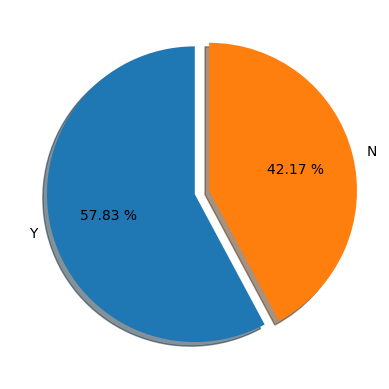

In [ ]:
data = train_data['status'].value_counts()

plt.figure()
plt.pie(data, labels = ['Y','N'],autopct='%.2f %%', shadow=True, explode=(0,0.1), startangle=90)
plt.show()

칼럼 수 :  22


100%|██████████| 22/22 [00:00<00:00, 60.75it/s]


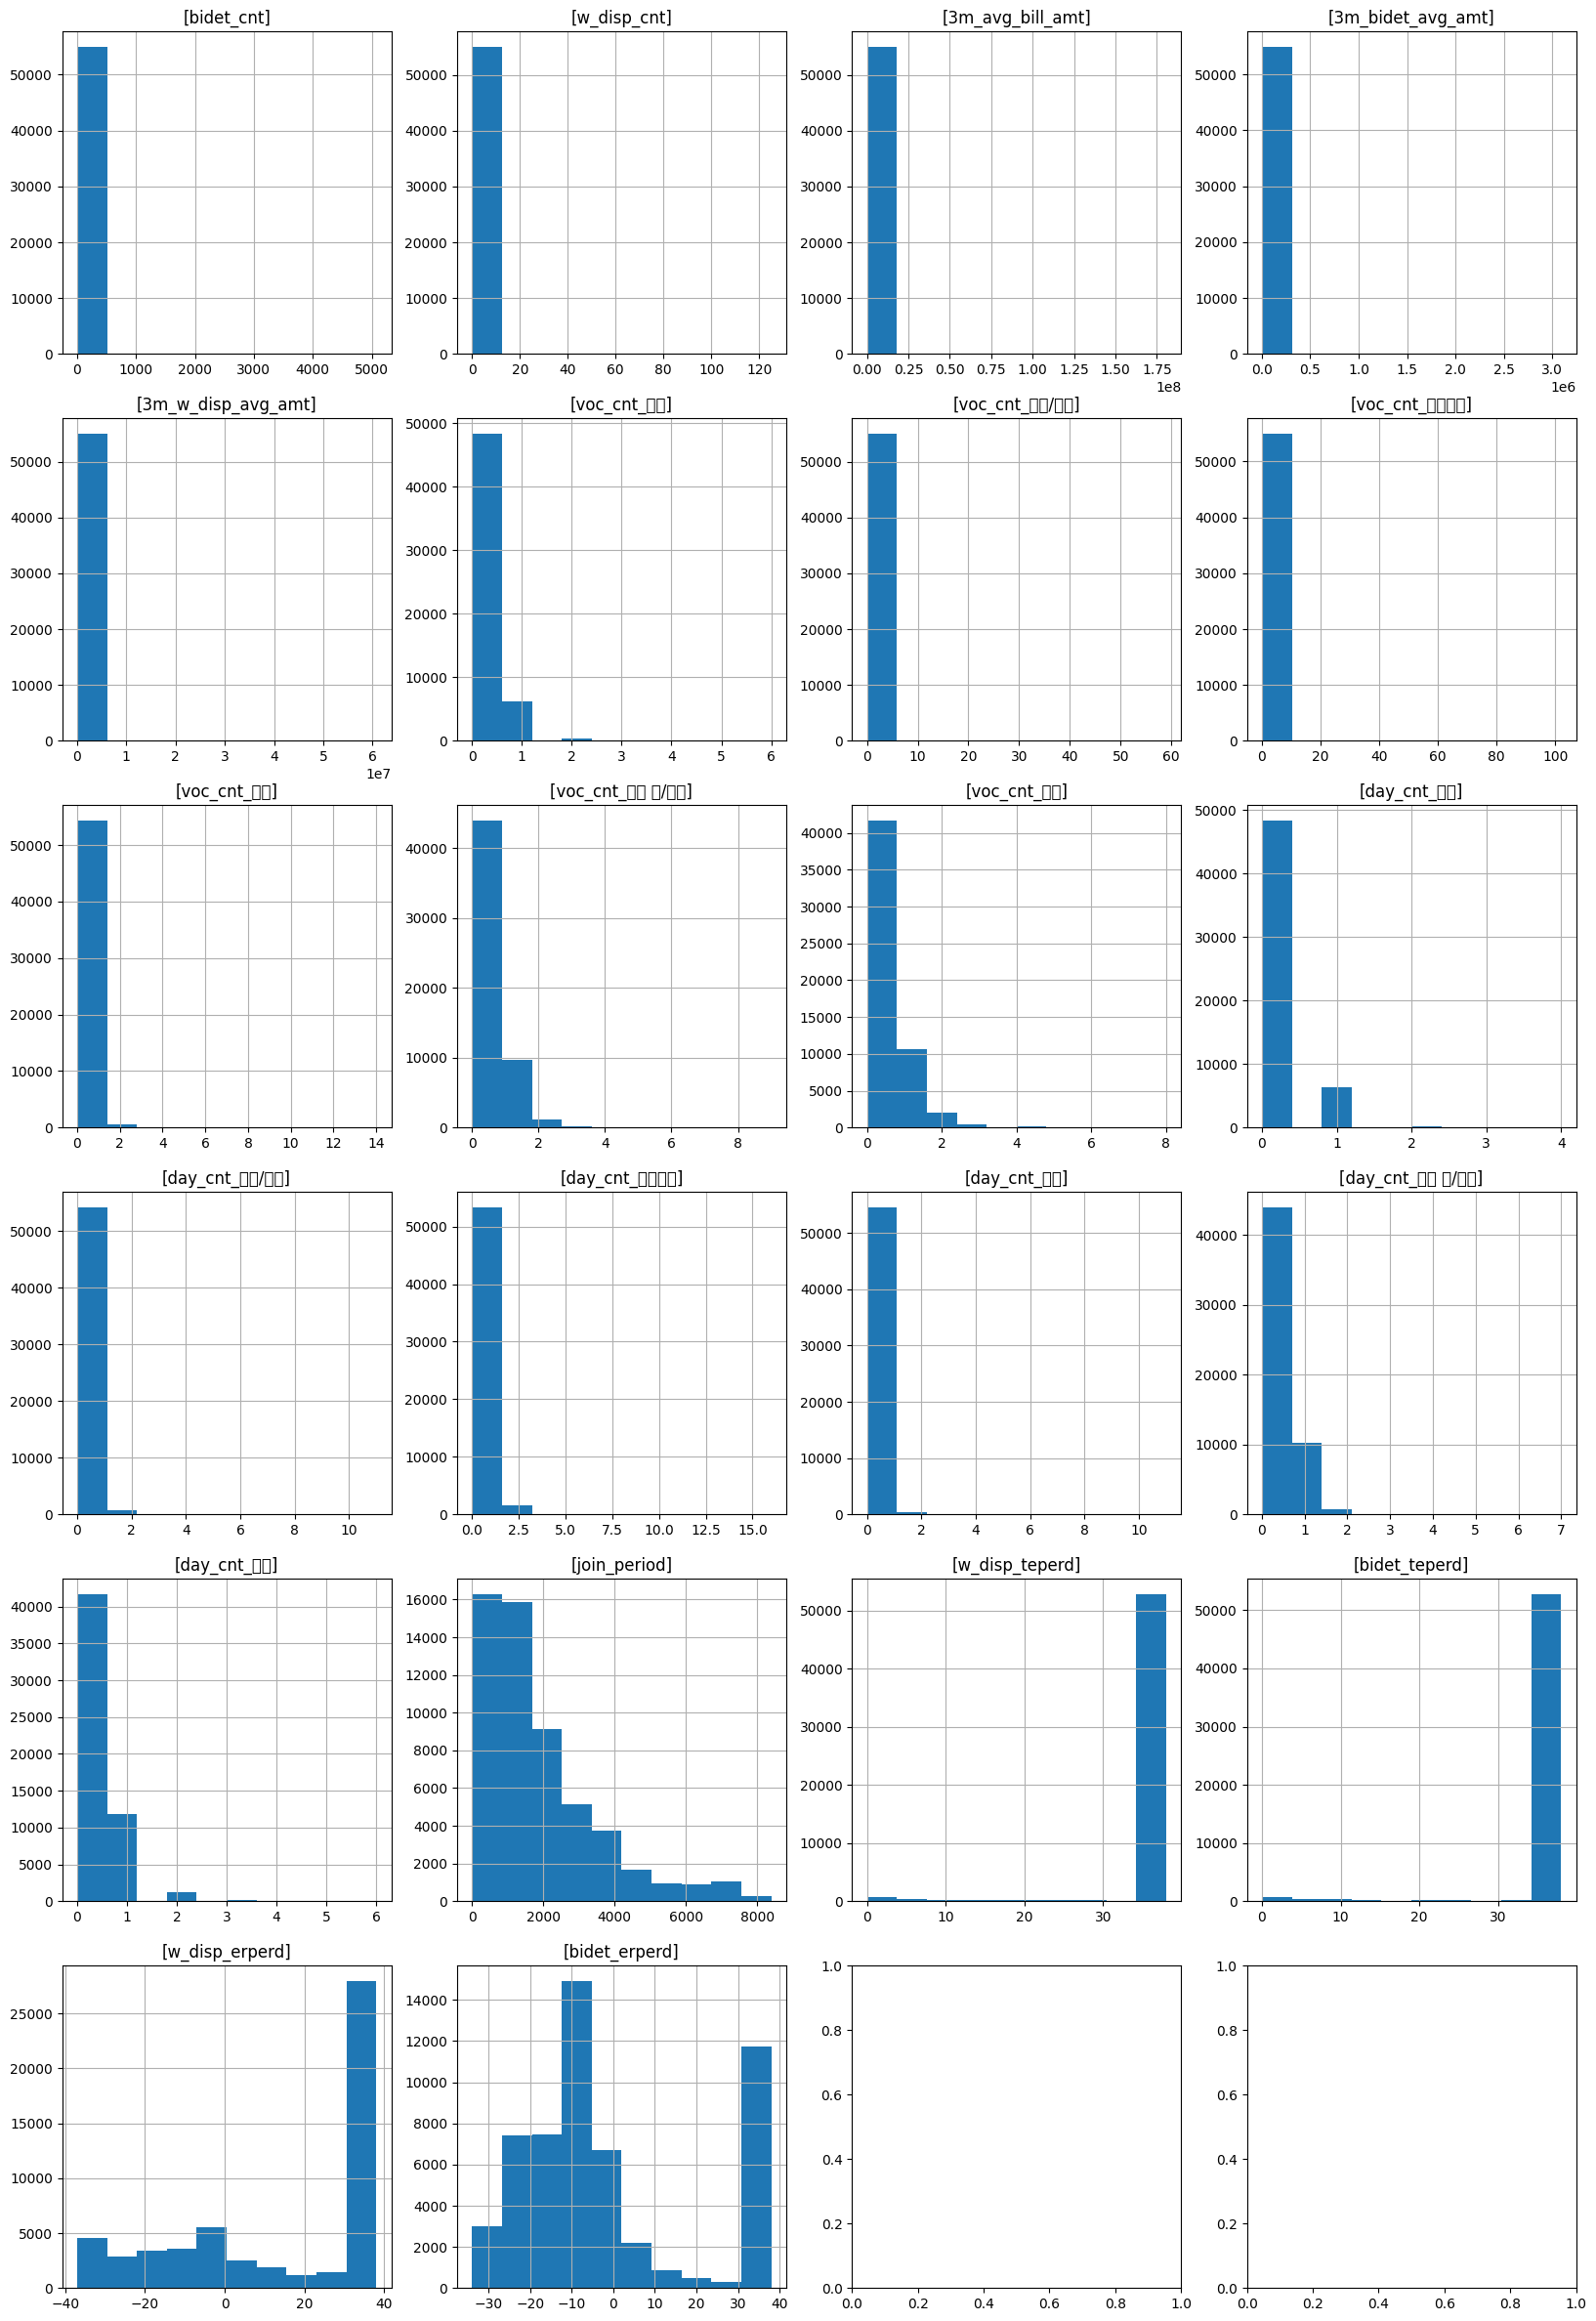

In [ ]:
import math

num_cols = train_data.select_dtypes(['int64', 'float64']).columns

def make_histplot(df, num_cols, label):
  col_cnt = 4
  graph_size = 5
  num = len(num_cols)
  print("칼럼 수 : ", num)

  #전체 figure figzise
  plt.rcParams['figure.figsize'] = (col_cnt * graph_size, math.ceil(num/col_cnt) * graph_size)

  fig, ax = plt.subplots(ncols = col_cnt, nrows=math.ceil(num/col_cnt))
  i=0
  for column in tqdm(num_cols):
    df[column].hist(ax = ax[int(i/col_cnt)][i%col_cnt])
    ax[int(i/col_cnt)][i%col_cnt].set_title('[' + column + ']')
    i += 1

  plt.show()

make_histplot(train_data, num_cols, 'status')


In [ ]:
#이상치 제거하고 다시 그려보기
outlier_cols = train_data.describe().loc['max'][train_data.describe().loc['max'] > 20].index.tolist()

In [ ]:
def outliers_iqr(df, column, uorl, upper=75, lower=25, factor=1.5):
  q1, q3 = np.percentile(df[column], [lower, upper])
  iqr = q3-q1
  if uorl == 'l':
    return (q1- (iqr*factor))
  elif uorl == 'u':
    return (q3 + (iqr*factor))

def replace_outlier(df,cols, upper=75, lower=25, factor=1.5):
  for column in cols:
    upperfence = outliers_iqr(df, column, 'u', upper, lower, factor)
    df[column] = df[column].apply(lambda x : x if x <= upperfence else upperfence)


train_data_del_outlier = train_data.copy()
replace_outlier(train_data_del_outlier, outlier_cols, factor=1.5)

칼럼 수 :  22


100%|██████████| 22/22 [00:00<00:00, 58.28it/s]


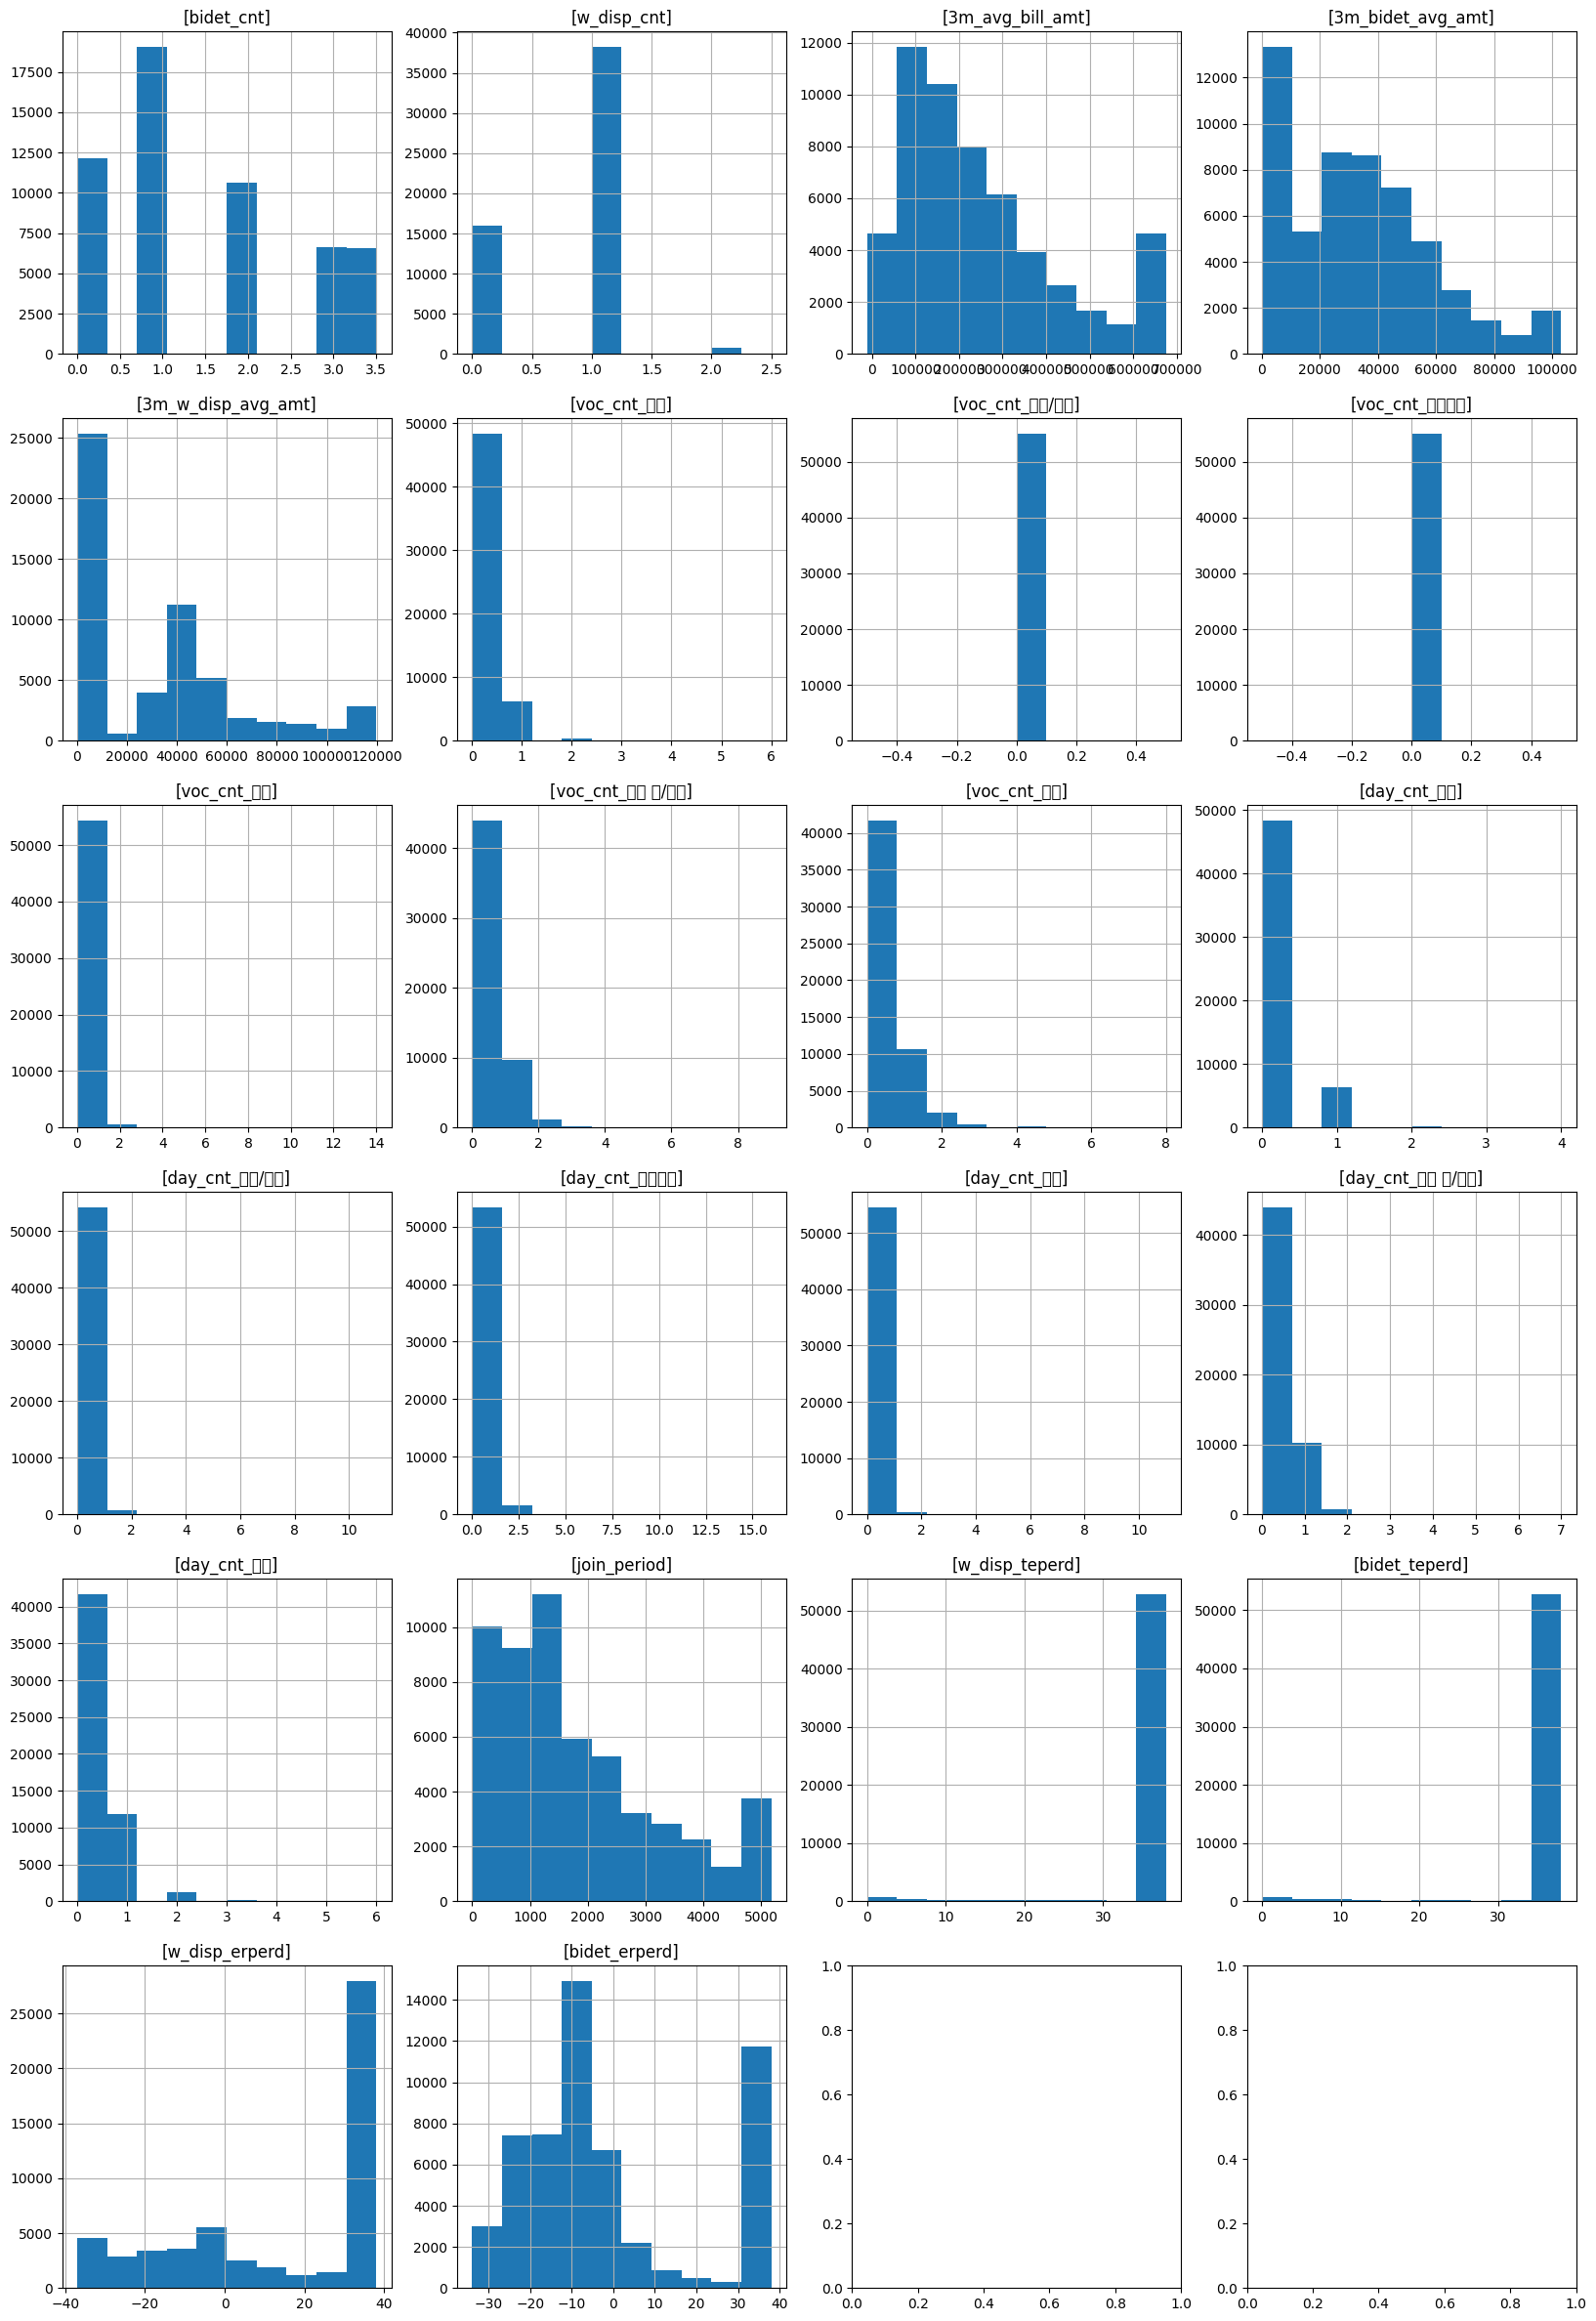

In [ ]:
make_histplot(train_data_del_outlier, num_cols, 'status')

100%|██████████| 22/22 [00:10<00:00,  2.18it/s]


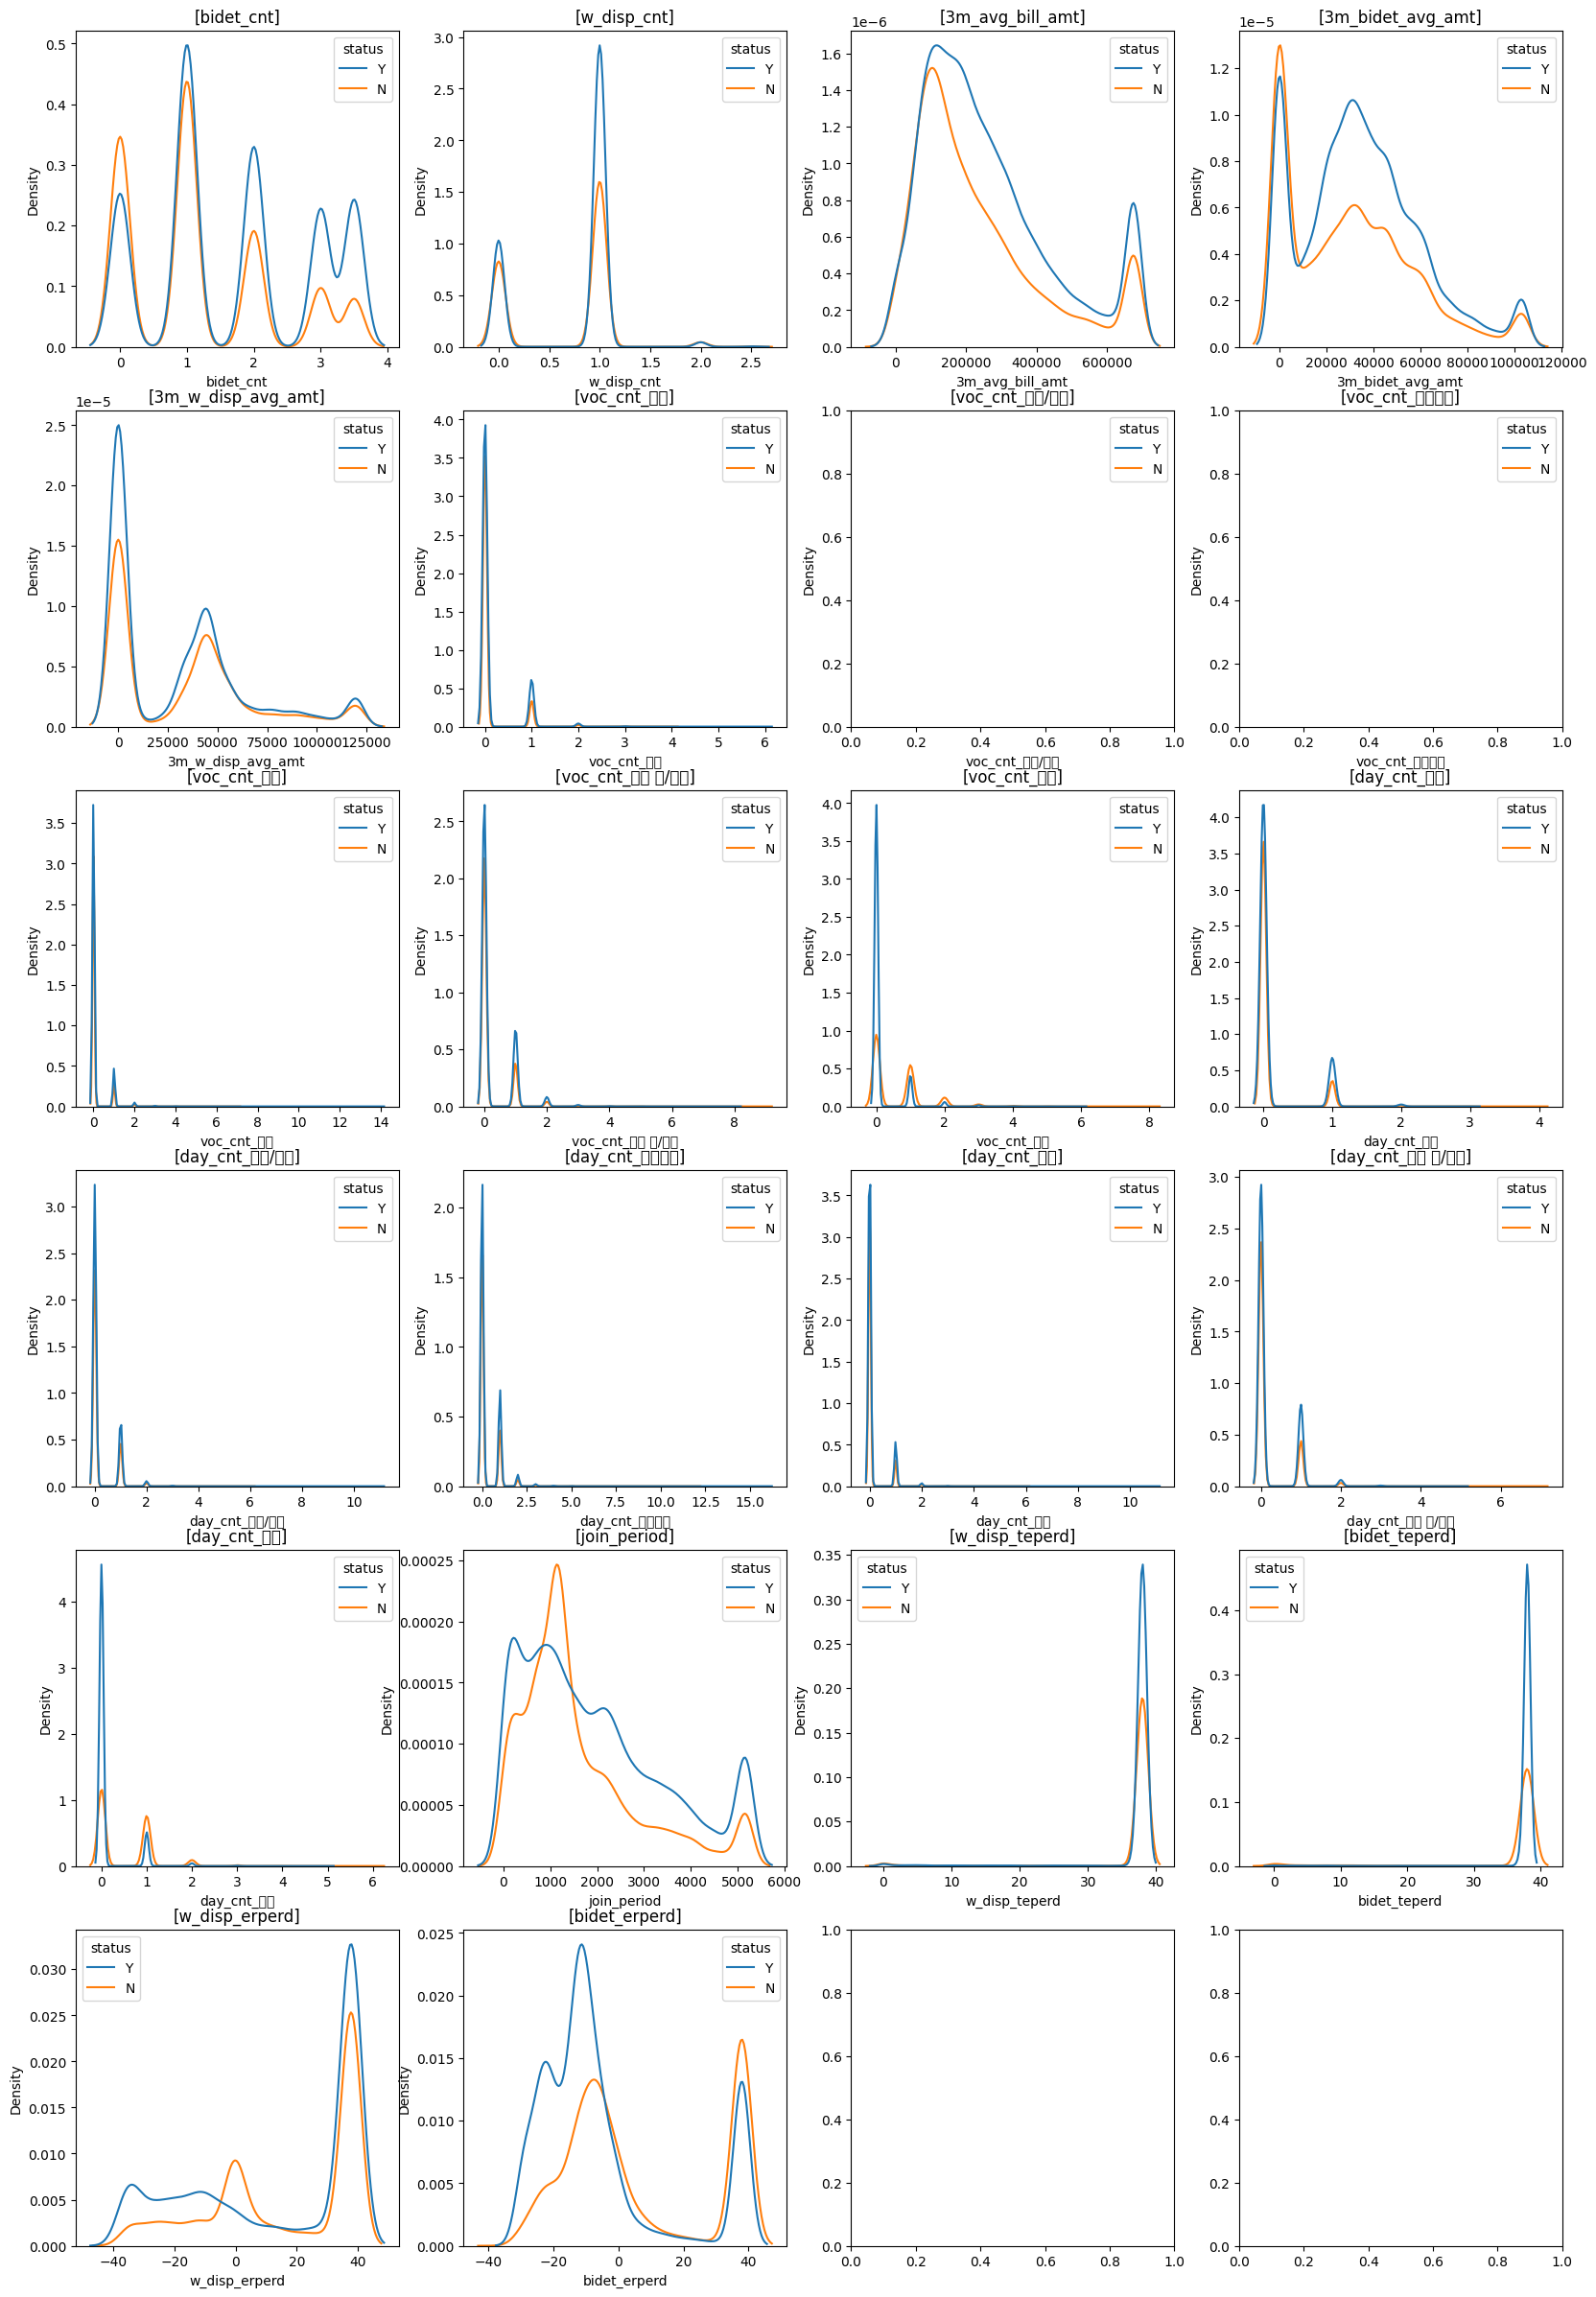

In [ ]:
def make_kdeplot(df, num_cols, label):
  num = len(num_cols)
  col_cnt=4
  graph_size = 5

  plt.rcParams['figure.figsize'] = (col_cnt * graph_size, math.ceil(num/col_cnt) * graph_size)

  fig, ax = plt.subplots(ncols = col_cnt, nrows = math.ceil(num/col_cnt))
  i=0
  for column in tqdm(num_cols):
    sns.kdeplot(data=df, x=column, hue=label, ax = ax[int(i/col_cnt)][i%col_cnt])
    ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')
    i+=1

  plt.show()

make_kdeplot(train_data_del_outlier, num_cols, 'status')

100%|██████████| 22/22 [00:12<00:00,  1.73it/s]


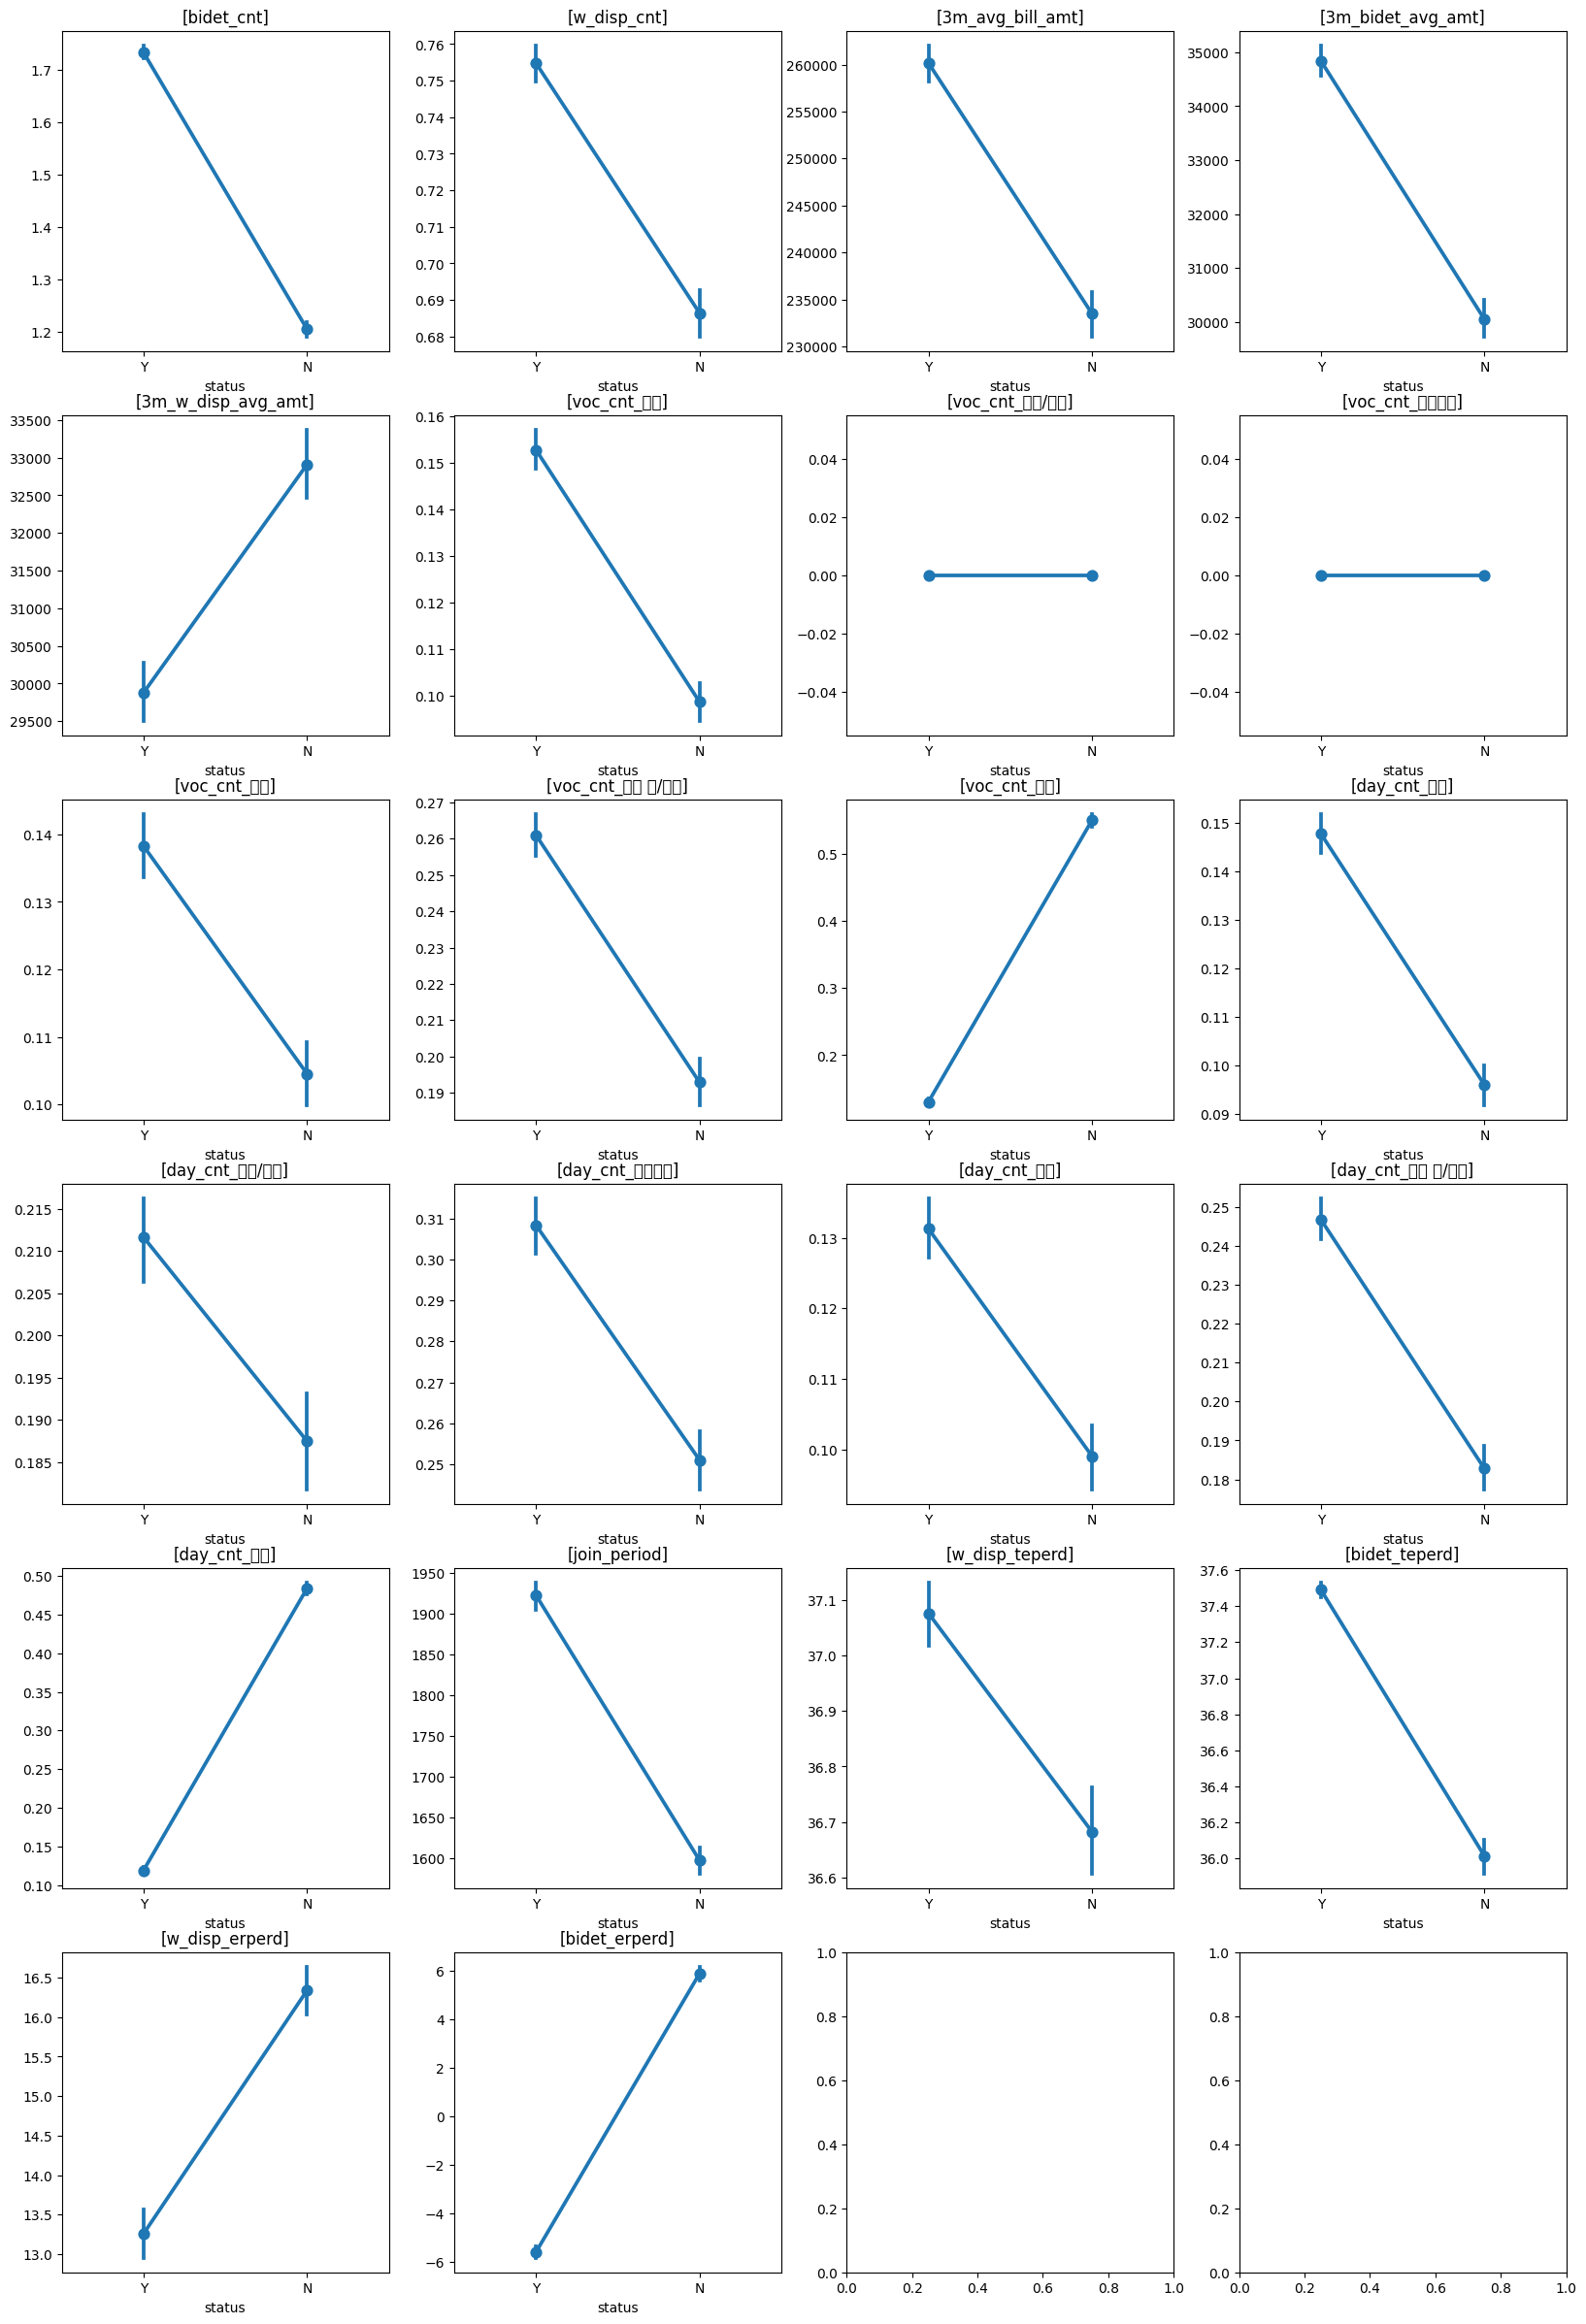

In [ ]:
def make_pointplot(df, num_cols, label):
  num = len(num_cols)
  col_cnt=4
  graph_size=5

  plt.rcParams['figure.figsize'] = (col_cnt * graph_size, math.ceil(num/col_cnt) * graph_size)

  fig, ax = plt.subplots(ncols = col_cnt, nrows = math.ceil(num/col_cnt))
  i=0
  for column in tqdm(num_cols):
    sns.pointplot(data=df, y=column, x=label, ax = ax[int(i/col_cnt)][i%col_cnt])

    ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')
    ax[int(i/col_cnt)][i%col_cnt].set_ylabel('')
    i+=1

  plt.show()

make_pointplot(train_data_del_outlier, num_cols, 'status')


In [ ]:
#@title 범주형 데이터 분석하기
obj_cols = train_data.select_dtypes('O').columns
obj_cols

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')

100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


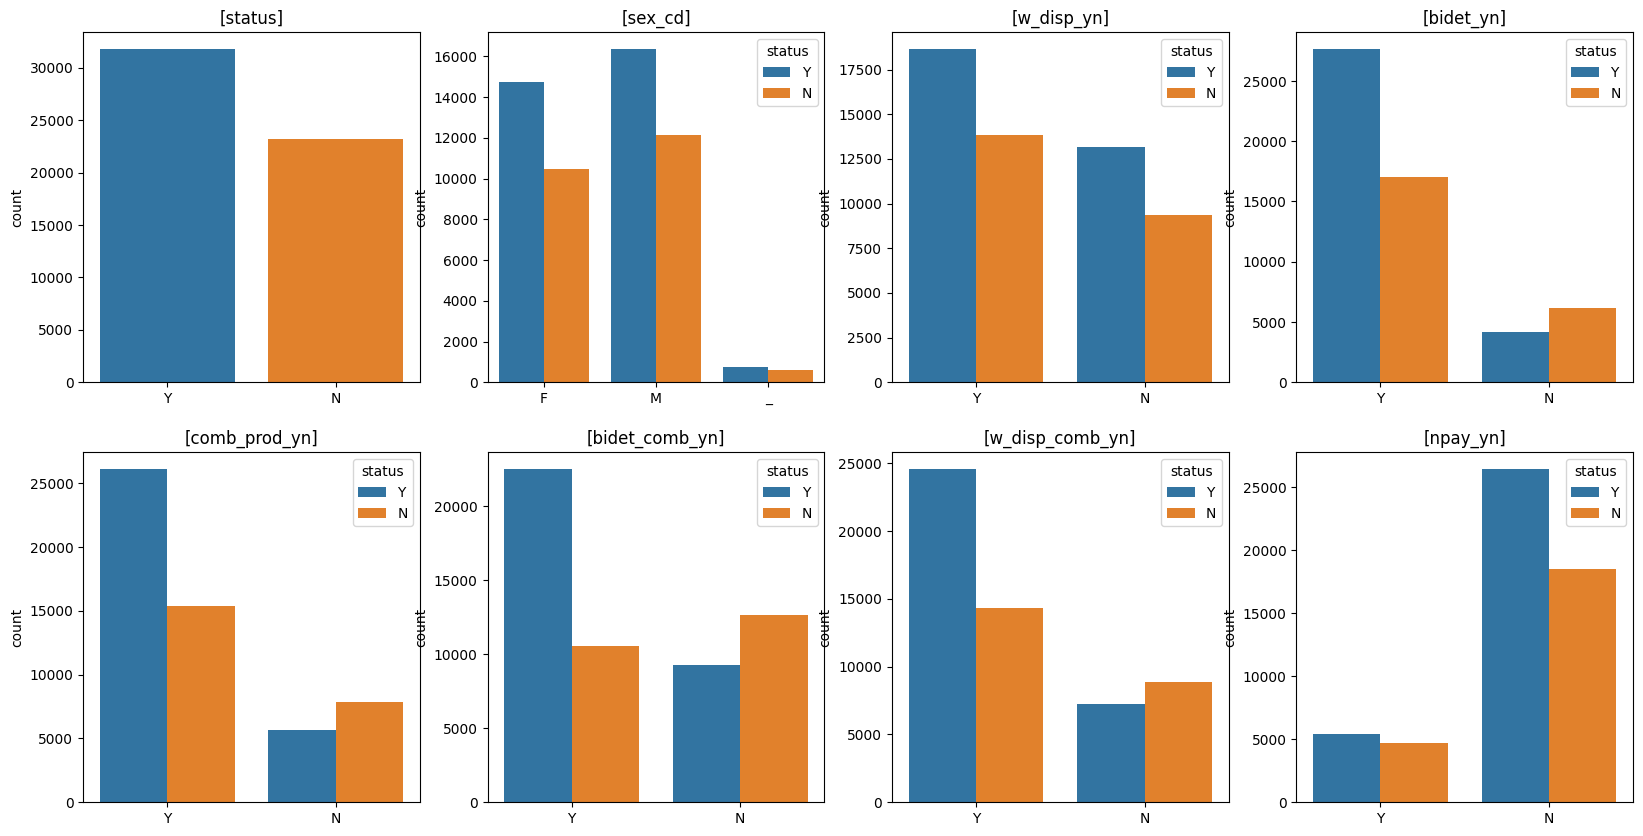

In [ ]:
def make_countplot(df, obj_cols, label):
  num = len(obj_cols)
  col_cnt=4
  graph_size=5

  plt.rcParams['figure.figsize'] = (col_cnt * graph_size, math.ceil(num/col_cnt) * graph_size)

  fig, ax = plt.subplots(ncols = col_cnt, nrows = math.ceil(num/col_cnt))
  i=0
  for column in tqdm(obj_cols):
    sns.countplot(data=df, x=column, hue=label, ax=ax[int(i/col_cnt)][i%col_cnt])

    ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')
    ax[int(i/col_cnt)][i%col_cnt].set_xlabel('')
    i+=1
  plt.show()

make_countplot(train_data, obj_cols, 'status')

#AI 모델링을 위한 전처리
(표준화, 정규화, 레이블인코딩, OH)

In [ ]:
numbers = ['int64','float64']
num_cols = train_data.select_dtypes(numbers).columns
train_data[num_cols].head(3)

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,voc_cnt_해지,day_cnt_가입,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,1,0.0,381711.0,40393,43560,0,0,0,0,1,0,0,0,0,0,1,0,1228,38,38,-9,-12
1,2,0.0,110100.0,34460,0,0,0,0,0,0,1,0,0,0,0,0,1,2463,38,38,38,-6
2,1,1.0,90000.0,0,28600,0,0,1,0,0,0,0,0,1,0,0,0,1127,38,38,0,38


In [ ]:
#@title 표준화
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
train_data[num_cols] = standardScaler.fit_transform(train_data[num_cols])
test_data[num_cols] = standardScaler.fit_transform(test_data[num_cols])
train_data[num_cols].head(3)

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,voc_cnt_해지,day_cnt_가입,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,-0.024020,-0.648376,0.106054,0.156062,0.004869,-0.354897,-0.388441,-0.375243,-0.311011,1.504600,-0.494412,-0.361635,-0.449705,-0.489858,-0.324489,1.678468,-0.526142,-0.389920,0.193677,0.198275,-0.886782,-0.507721
1,-0.008977,-0.648376,-0.213612,0.001277,-0.104990,-0.354897,-0.388441,-0.375243,-0.311011,-0.455211,1.115192,-0.361635,-0.449705,-0.489858,-0.324489,-0.472762,1.401761,0.374294,0.193677,0.198275,0.882517,-0.236914
2,-0.024020,0.231071,-0.237268,-0.897745,-0.032860,-0.354897,-0.388441,0.753461,-0.311011,-0.455211,-0.494412,-0.361635,-0.449705,1.233670,-0.324489,-0.472762,-0.526142,-0.452419,0.193677,0.198275,-0.547980,1.748998


In [ ]:
train_data.describe()

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,voc_cnt_해지,day_cnt_가입,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04
mean,-2.712981e-18,-5.083610e-17,2.170385e-17,-2.842171e-18,-4.844610e-18,-1.446923e-17,7.893484e-17,3.035955e-18,3.501038e-17,-1.098112e-17,-6.188181e-17,-9.650462e-17,4.825231e-17,1.653627e-17,-4.805853e-17,7.880565e-18,-1.627789e-17,-7.137725e-17,-3.214237e-16,3.225864e-16,-5.109448e-17,-1.421085e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-3.906204e-02,-6.483763e-01,-3.565643e-01,-8.977446e-01,-1.049899e-01,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,-4.944116e-01,-3.616351e-01,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-1.149802e+00,-6.558596e+00,-6.458014e+00,-1.940832e+00,-1.500677e+00
25%,-2.401956e-02,-6.483763e-01,-2.134368e-01,-6.026667e-01,-1.049899e-01,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,-4.944116e-01,-3.616351e-01,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-6.869425e-01,1.936772e-01,1.982746e-01,-8.867821e-01,-6.431238e-01
50%,-2.401956e-02,2.310707e-01,-1.084393e-01,-8.702069e-02,-2.262107e-02,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,-4.944116e-01,-3.616351e-01,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-3.100954e-01,1.936772e-01,1.982746e-01,6.942933e-01,-3.271832e-01
75%,-8.977078e-03,2.310707e-01,5.265599e-02,3.555961e-01,1.585976e-02,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,-4.944116e-01,-3.616351e-01,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,4.077088e-01,1.936772e-01,1.982746e-01,8.825166e-01,3.498324e-01
max,7.633160e+01,1.092825e+02,2.122352e+02,7.978902e+01,1.531834e+02,1.603414e+01,1.063694e+02,1.147525e+02,3.478769e+01,1.718309e+01,1.238241e+01,1.112713e+01,2.410769e+01,2.708659e+01,3.000389e+01,1.458585e+01,1.104128e+01,4.045614e+00,1.936772e-01,1.982746e-01,8.825166e-01,1.748998e+00


In [ ]:
#@title 정규화
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()

train_data[num_cols] = minMaxScaler.fit_transform(train_data[num_cols])
test_data[num_cols] = minMaxScaler.fit_transform(test_data[num_cols])
train_data[num_cols].head(3)


,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,voc_cnt_해지,day_cnt_가입,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,0.000197,0.000,0.002176,0.013060,0.000717,0.0,0.0,0.000000,0.0,0.111111,0.000,0.0,0.0,0.0000,0.0,0.142857,0.000000,0.146260,1.0,1.0,0.373333,0.305556
1,0.000394,0.000,0.000672,0.011142,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.0,0.0000,0.0,0.000000,0.166667,0.293354,1.0,1.0,1.000000,0.388889
2,0.000197,0.008,0.000561,0.000000,0.000471,0.0,0.0,0.009804,0.0,0.000000,0.000,0.0,0.0,0.0625,0.0,0.000000,0.000000,0.134231,1.0,1.0,0.493333,1.000000


In [ ]:
#@title 레이블 인코딩
le_columns = train_data.select_dtypes('O').columns
le_columns

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for column in le_columns:
  le.fit(train_data[column])
  train_data[column] = le.transform(train_data[column])

  for label in np.unique(test_data[column]):
    if label not in le.classes_:
      le.classes_ = np.append(le.classes_, label)

  test_data[column] = le.transform(test_data[column])


In [ ]:
le.classes_

array(['N', 'Y'], dtype=object)

In [ ]:
train_data[le_columns].head(3) #N=0, Y=1

,status,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn
0,1,0,1,1,1,1,1,1
1,0,1,0,1,0,0,0,0
2,0,1,1,0,1,1,1,0


In [ ]:
#status N=0, Y=1이 아니라 Y=0, N=1로 만들기
train_data['status'] = train_data['status'].map(lambda x : 1 if x==0 else 0)
test_data['status'] = test_data['status'].apply(lambda x : 1 if x==0 else 0)

In [ ]:
#@title OH
for column in le_columns:
  print(train_data[column].value_counts())

status
0    31806
1    23194
Name: count, dtype: int64
sex_cd
1    28486
0    25178
2     1336
Name: count, dtype: int64
w_disp_yn
1    32474
0    22526
Name: count, dtype: int64
bidet_yn
1    44657
0    10343
Name: count, dtype: int64
comb_prod_yn
1    41462
0    13538
Name: count, dtype: int64
bidet_comb_yn
1    33075
0    21925
Name: count, dtype: int64
w_disp_comb_yn
1    38924
0    16076
Name: count, dtype: int64
npay_yn
0    44920
1    10080
Name: count, dtype: int64


In [ ]:
#sex_code 값만 3개임
oh_columns=['sex_cd']

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False, drop='if_binary')
train_onehot = enc.fit_transform(train_data[oh_columns])
test_onehot = enc.fit_transform(test_data[oh_columns])

train_onehot

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
#OH 결과 합치기, 기존 칼럼 삭제하기
train_data_OH = pd.concat([train_data,
                           pd.DataFrame(train_onehot, columns=enc.get_feature_names_out(oh_columns))],
                          axis=1)
test_data_OH = pd.concat([test_data,
                          pd.DataFrame(test_onehot, columns=enc.get_feature_names_out(oh_columns))],
                         axis=1)
train_data_OH.drop(oh_columns, axis=1, inplace=True)
test_data_OH.drop(oh_columns, axis=1, inplace=True)

In [ ]:
train_data_OH.head(3)

,status,bidet_cnt,w_disp_cnt,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,voc_cnt_해지,day_cnt_가입,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd,sex_cd_0,sex_cd_1,sex_cd_2
0,0,0.000197,0.000,1,1,1,1,1,1,0.002176,0.013060,0.000717,0.0,0.0,0.000000,0.0,0.111111,0.000,0.0,0.0,0.0000,0.0,0.142857,0.000000,0.146260,1.0,1.0,0.373333,0.305556,1.0,0.0,0.0
1,1,0.000394,0.000,0,1,0,0,0,0,0.000672,0.011142,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.0,0.0000,0.0,0.000000,0.166667,0.293354,1.0,1.0,1.000000,0.388889,0.0,1.0,0.0
2,1,0.000197,0.008,1,0,1,1,1,0,0.000561,0.000000,0.000471,0.0,0.0,0.009804,0.0,0.000000,0.000,0.0,0.0,0.0625,0.0,0.000000,0.000000,0.134231,1.0,1.0,0.493333,1.000000,0.0,1.0,0.0


In [ ]:
train_data = train_data_OH
test_data = test_data_OH

<Axes: >

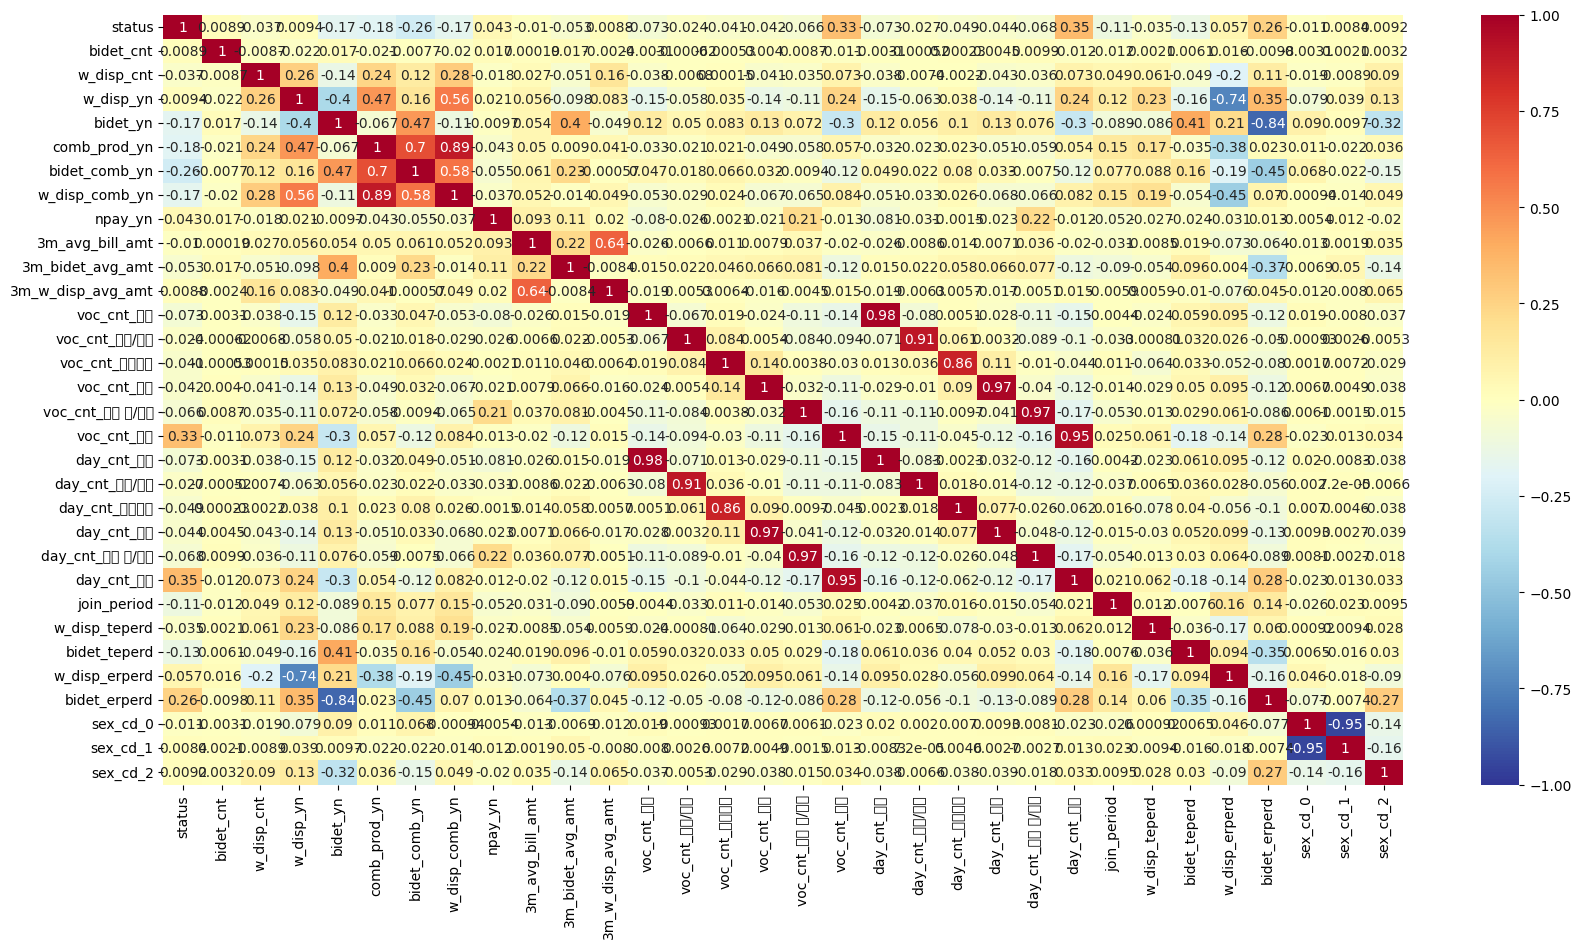

In [ ]:
#@title 다중공선성 제거하기
train_corr = train_data.corr()
sns.heatmap(train_corr, annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1)

In [ ]:
check = []
mcol_linearity=[]

for idx in train_corr.index:
  check.append(idx)
  for column in train_corr.columns:
    if column not in check:
      if (((train_corr.loc[idx, column] >= 0.9) and (train_corr.loc[idx, column] <1)) or
          ((train_corr.loc[idx, column] <= -0.9) and (train_corr.loc[idx, column] >-1))):
          mcol_linearity.append([idx,column])

In [ ]:
mcol_linearity

[['voc_cnt_가입', 'day_cnt_가입'],
 ['voc_cnt_변경/조회', 'day_cnt_변경/조회'],
 ['voc_cnt_이용', 'day_cnt_이용'],
 ['voc_cnt_청구 수/미납', 'day_cnt_청구 수/미납'],
 ['voc_cnt_해지', 'day_cnt_해지'],
 ['sex_cd_0', 'sex_cd_1']]

In [ ]:
#@title VIF 확인하기
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(train_data.values, i) for i in tqdm(range(train_data.shape[1]))]
vif['Feature'] = train_data.columns
vif = vif.sort_values(by='VIF_Factor', ascending=False).reset_index()
vif

100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


,index,VIF_Factor,Feature
0,30,80.575735,sex_cd_1
1,29,71.338545,sex_cd_0
2,18,30.152586,day_cnt_가입
3,12,29.990095,voc_cnt_가입
4,15,19.843187,voc_cnt_이용
5,21,19.705031,day_cnt_이용
6,22,17.886209,day_cnt_청구 수/미납
7,16,17.683989,voc_cnt_청구 수/미납
8,23,10.156465,day_cnt_해지
9,17,9.917503,voc_cnt_해지


In [ ]:
del_cols = ['sex_cd_1', 'voc_cnt_가입', 'voc_cnt_이용', 'voc_cnt_청구 수/미납', 'voc_cnt_해지']

train_data = train_data.drop(del_cols, axis=1)
test_data = test_data.drop(del_cols, axis=1)

In [ ]:
train_data.columns

Index(['status', 'bidet_cnt', 'w_disp_cnt', 'w_disp_yn', 'bidet_yn',
       'comb_prod_yn', 'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn',
       '3m_avg_bill_amt', '3m_bidet_avg_amt', '3m_w_disp_avg_amt',
       'voc_cnt_변경/조회', 'voc_cnt_업무협조', 'day_cnt_가입', 'day_cnt_변경/조회',
       'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_청구 수/미납', 'day_cnt_해지',
       'join_period', 'w_disp_teperd', 'bidet_teperd', 'w_disp_erperd',
       'bidet_erperd', 'sex_cd_0', 'sex_cd_2'],
      dtype='object')

#모델링과 평가하기

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data.drop('status', axis=1),
                                                  train_data['status'],
                                                  random_state = 10, stratify = train_data['status'])

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((41250, 26), (13750, 26), (41250,), (13750,))

In [ ]:
X_test = test_data.drop('status', axis=1)
y_test = test_data['status']
X_test.shape, y_test.shape

((5000, 26), (5000,))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
result = pd.DataFrame([], columns = ['acc','recall','precision','F1-score'])

def result_view(model_name, pred, actual):
  acc = round(accuracy_score(actual, pred), 3)
  precision = round(precision_score(actual, pred), 3)
  recall = round(recall_score(actual, pred), 3)
  F1 = round(f1_score(actual, pred), 3)

  result.loc[model_name] = (acc, recall, precision, F1)
  result.sort_values(by='acc', inplace=True, ascending=False)

  plt.figure(figsize=(8,5))

  for idx in result.index:
    x_values = result.columns
    y_values = result.loc[idx]

    plt.plot(x_values, y_values)
    plt.annotate(text=round(result.loc[idx, 'acc'], 3),
                 xy = (0, result.loc[idx, 'acc']), ha='center', fontsize=14)
    plt.annotate(text=round(result.loc[idx, 'recall'], 3),
                 xy = (1, result.loc[idx, 'recall']), ha='center', fontsize=14)
    plt.annotate(text=round(result.loc[idx, 'precision'], 3),
                 xy = (2, result.loc[idx, 'precision']), ha='center', fontsize=14)
    plt.annotate(text=round(result.loc[idx, 'F1-score'], 3),
                 xy = (3, result.loc[idx, 'F1-score']), ha='center', fontsize=14)
  plt.legend(result.index, loc=4)
  plt.show()


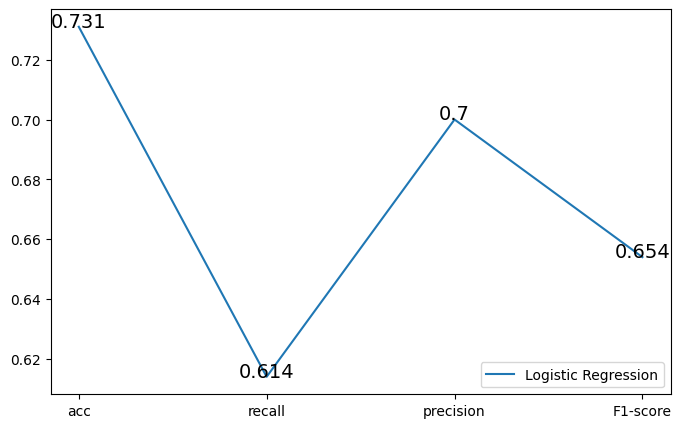

In [ ]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(random_state=21)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)
result_view('Logistic Regression', pred_lr, y_test)

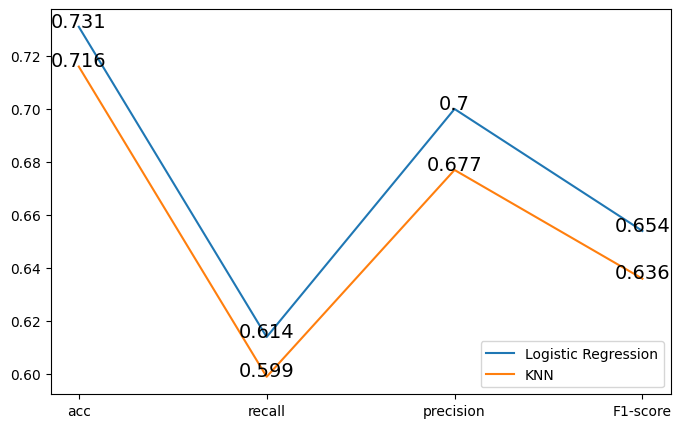

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
pred_knn = model_knn.predict(X_test)
result_view('KNN', pred_knn, y_test)

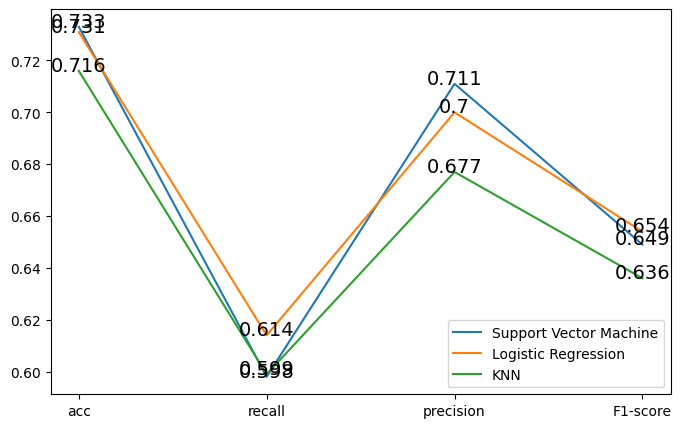

In [ ]:
from sklearn.svm import SVC
model_svm = SVC(random_state = 21)
model_svm.fit(X_train, y_train)
pred_svm = model_svm.predict(X_test)
result_view('Support Vector Machine', pred_svm, y_test)

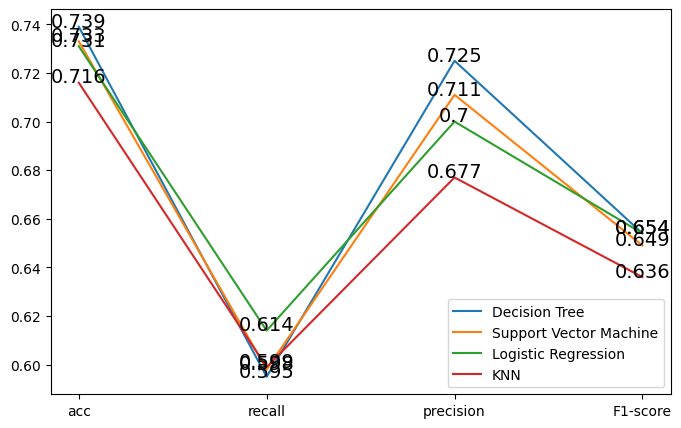

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(min_samples_split = 2,
                                  min_samples_leaf=1,
                                  max_features=None,
                                  max_depth=5,
                                  max_leaf_nodes=None,
                                  random_state=21
                                  )
model_dt.fit(X_train, y_train)
pred_dt = model_dt.predict(X_test)
result_view('Decision Tree', pred_dt, y_test)

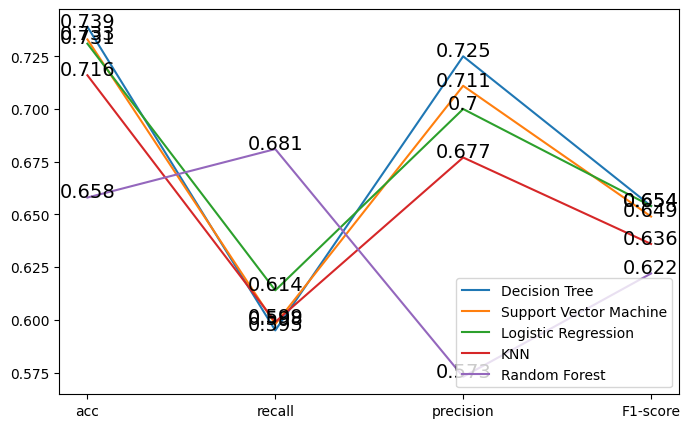

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_jobs=-1, n_estimators = 100,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  #max_features='auto',
                                  max_depth = None,
                                  max_leaf_nodes = None,
                                  random_state=21
                                  )
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)
result_view('Random Forest', pred_rf, y_test)

In [ ]:
pip uninstall xgboost

Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/xgboost-2.1.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/xgboost.libs/libgomp-24e2ab19.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/xgboost/*
Proceed (Y/n)? Y
  Successfully uninstalled xgboost-2.1.4


In [ ]:
pip install xgboost==1.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 MB 4.0 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(learning_rate = 0.1, n_jobs = -1,
                              n_estimators = 500,
                              random_state = 21)
eval_set = [(X_val, y_val)]
model_xgb.fit(X_train, y_train, #early_stopping_rounds=10,eval_metric='logloss',
               eval_set = eval_set, verbose=True)

pred_xgb = model_xgb(X_test)
result_view('XGBoost', pred_xgb, y_test)

[0]	validation_0-logloss:0.65290
[1]	validation_0-logloss:0.62993
[2]	validation_0-logloss:0.61103
[3]	validation_0-logloss:0.59529
[4]	validation_0-logloss:0.58209
[5]	validation_0-logloss:0.57138
[6]	validation_0-logloss:0.56157
[7]	validation_0-logloss:0.55356
[8]	validation_0-logloss:0.54624
[9]	validation_0-logloss:0.54026
[10]	validation_0-logloss:0.53512
[11]	validation_0-logloss:0.53039
[12]	validation_0-logloss:0.52604
[13]	validation_0-logloss:0.52279
[14]	validation_0-logloss:0.51946
[15]	validation_0-logloss:0.51683
[16]	validation_0-logloss:0.51415
[17]	validation_0-logloss:0.51205
[18]	validation_0-logloss:0.50983
[19]	validation_0-logloss:0.50832
[20]	validation_0-logloss:0.50652
[21]	validation_0-logloss:0.50499
[22]	validation_0-logloss:0.50394
[23]	validation_0-logloss:0.50293
[24]	validation_0-logloss:0.50171
[25]	validation_0-logloss:0.50063
[26]	validation_0-logloss:0.49955
[27]	validation_0-logloss:0.49879
[28]	validation_0-logloss:0.49817
[29]	validation_0-loglos

TypeError: 'XGBClassifier' object is not callable

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


0:	learn: 0.6825262	test: 0.6824197	best: 0.6824197 (0)	total: 19ms	remaining: 37.9s
1:	learn: 0.6730963	test: 0.6728398	best: 0.6728398 (1)	total: 32.6ms	remaining: 32.6s
2:	learn: 0.6649270	test: 0.6645339	best: 0.6645339 (2)	total: 45.9ms	remaining: 30.5s
3:	learn: 0.6568667	test: 0.6563148	best: 0.6563148 (3)	total: 60.3ms	remaining: 30.1s
4:	learn: 0.6484773	test: 0.6477619	best: 0.6477619 (4)	total: 74.5ms	remaining: 29.7s
5:	learn: 0.6410742	test: 0.6402099	best: 0.6402099 (5)	total: 88.4ms	remaining: 29.4s
6:	learn: 0.6337583	test: 0.6328092	best: 0.6328092 (6)	total: 104ms	remaining: 29.6s
7:	learn: 0.6267501	test: 0.6256670	best: 0.6256670 (7)	total: 123ms	remaining: 30.6s
8:	learn: 0.6213121	test: 0.6201290	best: 0.6201290 (8)	total: 136ms	remaining: 30.1s
9:	learn: 0.6154216	test: 0.6141160	best: 0.6141160 (9)	total: 150ms	remaining: 29.8s
10:	learn: 0.6101913	test: 0.6088540	best: 0.6088540 (10)	total: 163ms	remaining: 29.4s
11:	learn: 0.6052461	test: 0.6039382	best: 0.603

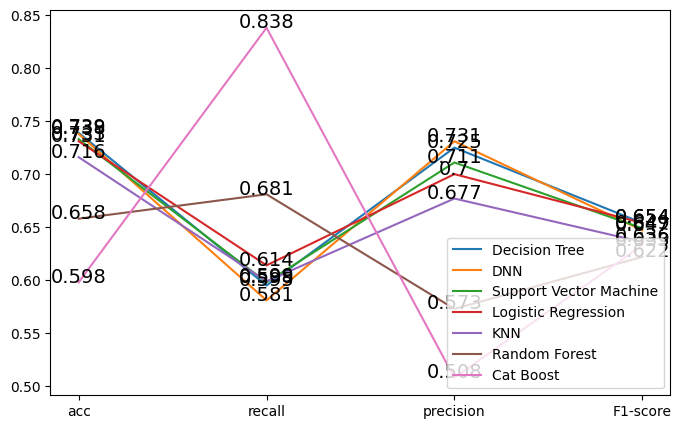

In [ ]:
from catboost import CatBoostClassifier, Pool
cat = CatBoostClassifier(learning_rate=0.03, iterations=2000, random_state=21)

train_dataset = Pool(data=X_train, label = y_train)
eval_dataset = Pool(data=X_val, label = y_val)

cat.fit(train_dataset, eval_set = eval_dataset, early_stopping_rounds=30)
pred_cat = cat.predict(X_test)
result_view('Cat Boost', pred_cat, y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

initializer = tf.keras.initializers.GlorotUniform(seed=42)
dnn=Sequential()
dnn.add(Dense(8, activation='relu', input_shape=(26,), kernel_initializer = initializer))
dnn.add(Dropout(0.2))
dnn.add(Dense(2, activation='relu'))
dnn.add(Dropout(0.2))
dnn.add(Dense(1, activation='sigmoid'))
dnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 8)              │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237 (948.00 B)

 Trainable params: 237 (948.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train.shape, y_train.shape

((41250, 26), (41250,))

In [ ]:
dnn.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1, patience=5)
check_point = ModelCheckpoint('best_model.h5', verbose=1,
                              monitor = 'val_loss', mode='min', save_best_only=True)

history = dnn.fit(x = X_train, y = y_train, epochs=50, batch_size=20,
                  validation_data = (X_val, y_val), verbose=1,
                  callbacks = [early_stop, check_point])

Epoch 1/50
2060/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5529 - loss: 0.6904
Epoch 1: val_loss improved from inf to 0.62059, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5529 - loss: 0.6903 - val_accuracy: 0.6911 - val_loss: 0.6206
Epoch 2/50
2056/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6373 - loss: 0.6333
Epoch 2: val_loss improved from 0.62059 to 0.59568, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6373 - loss: 0.6333 - val_accuracy: 0.7286 - val_loss: 0.5957
Epoch 3/50
2049/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6425 - loss: 0.6226
Epoch 3: val_loss improved from 0.59568 to 0.58456, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6425 - loss: 0.6226 - val_accuracy: 0.7300 - val_loss: 0.5846
Epoch 4/50
2057/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6548 - loss: 0.6142
Epoch 4: val_loss did not improve from 0.58456
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6548 - loss: 0.6142 - val_accuracy: 0.7272 - val_loss: 0.5850
Epoch 5/50
2056/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6527 - loss: 0.6128
Epoch 5: val_loss improved from 0.58456 to 0.58338, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6527 - loss: 0.6128 - val_accuracy: 0.7278 - val_loss: 0.5834
Epoch 6/50
2057/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6565 - loss: 0.6106
Epoch 6: val_loss improved from 0.58338 to 0.58084, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6565 - loss: 0.6106 - val_accuracy: 0.7273 - val_loss: 0.5808
Epoch 7/50
2049/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6541 - loss: 0.6115
Epoch 7: val_loss improved from 0.58084 to 0.57808, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6541 - loss: 0.6115 - val_accuracy: 0.7285 - val_loss: 0.5781
Epoch 8/50
2062/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6593 - loss: 0.6071
Epoch 8: val_loss improved from 0.57808 to 0.57451, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6593 - loss: 0.6071 - val_accuracy: 0.7296 - val_loss: 0.5745
Epoch 9/50
2042/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6605 - loss: 0.6069
Epoch 9: val_loss did not improve from 0.57451
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6605 - loss: 0.6070 - val_accuracy: 0.7285 - val_loss: 0.5765
Epoch 10/50
2043/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6609 - loss: 0.6077
Epoch 10: val_loss did not improve from 0.57451
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6609 - loss: 0.6077 - val_accuracy: 0.7289 - val_loss: 0.5749
Epoch 11/50
2059/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6560 - loss: 0.6096
Epoch 11: val_loss improved from 0.57451 to 0.57394, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6560 - loss: 0.6096 - val_accuracy: 0.7318 - val_loss: 0.5739
Epoch 12/50
2062/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6658 - loss: 0.6033
Epoch 12: val_loss did not improve from 0.57394
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6658 - loss: 0.6033 - val_accuracy: 0.7295 - val_loss: 0.5759
Epoch 13/50
2055/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6616 - loss: 0.6036
Epoch 13: val_loss improved from 0.57394 to 0.55539, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6615 - loss: 0.6036 - val_accuracy: 0.7291 - val_loss: 0.5554
Epoch 14/50
2048/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6610 - loss: 0.5873
Epoch 14: val_loss improved from 0.55539 to 0.54676, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6610 - loss: 0.5873 - val_accuracy: 0.7319 - val_loss: 0.5468
Epoch 15/50
2051/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6924 - loss: 0.5812
Epoch 15: val_loss did not improve from 0.54676
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6924 - loss: 0.5812 - val_accuracy: 0.7335 - val_loss: 0.5485
Epoch 16/50
2053/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6915 - loss: 0.5803
Epoch 16: val_loss did not improve from 0.54676
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6915 - loss: 0.5803 - val_accuracy: 0.7332 - val_loss: 0.5477
Epoch 17/50
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6972 - loss: 0.5770
Epoch 17: val_loss did not improve from 0.54676
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6972 - loss: 0.5770 - val_accuracy: 0.7341 - val_loss: 0.5490
Epoch 18/50
2040/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6986 - loss: 0.5744
Epoch 18: val_loss im

2063/2063 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6986 - loss: 0.5745 - val_accuracy: 0.7347 - val_loss: 0.5467
Epoch 19/50
2048/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6966 - loss: 0.5760
Epoch 19: val_loss improved from 0.54670 to 0.54415, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6966 - loss: 0.5760 - val_accuracy: 0.7345 - val_loss: 0.5441
Epoch 20/50
2045/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6972 - loss: 0.5745
Epoch 20: val_loss did not improve from 0.54415
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6972 - loss: 0.5745 - val_accuracy: 0.7367 - val_loss: 0.5446
Epoch 21/50
2053/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6990 - loss: 0.5732
Epoch 21: val_loss did not improve from 0.54415
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6989 - loss: 0.5732 - val_accuracy: 0.7372 - val_loss: 0.5458
Epoch 22/50
2046/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6982 - loss: 0.5753
Epoch 22: val_loss did not improve from 0.54415
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6982 - loss: 0.5753 - val_accuracy: 0.7376 - val_loss: 0.5464
Epoch 23/50
2044/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6972 - loss: 0.5765
Epoch 23: val_loss did n

2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6978 - loss: 0.5760 - val_accuracy: 0.7353 - val_loss: 0.5440
Epoch 25/50
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6969 - loss: 0.5765
Epoch 25: val_loss did not improve from 0.54398
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6969 - loss: 0.5765 - val_accuracy: 0.7387 - val_loss: 0.5441
Epoch 26/50
2050/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6960 - loss: 0.5760
Epoch 26: val_loss did not improve from 0.54398
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6960 - loss: 0.5760 - val_accuracy: 0.7357 - val_loss: 0.5449
Epoch 27/50
2060/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6950 - loss: 0.5754
Epoch 27: val_loss did not improve from 0.54398
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6950 - loss: 0.5754 - val_accuracy: 0.7358 - val_loss: 0.5456
Epoch 28/50
2041/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6949 - loss: 0.5748
Epoch 28: val_loss impr

2063/2063 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6949 - loss: 0.5749 - val_accuracy: 0.7367 - val_loss: 0.5439
Epoch 29/50
2050/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6987 - loss: 0.5736
Epoch 29: val_loss improved from 0.54394 to 0.54340, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6986 - loss: 0.5736 - val_accuracy: 0.7384 - val_loss: 0.5434
Epoch 30/50
2041/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6962 - loss: 0.5757
Epoch 30: val_loss improved from 0.54340 to 0.54295, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6961 - loss: 0.5757 - val_accuracy: 0.7369 - val_loss: 0.5430
Epoch 31/50
2047/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6959 - loss: 0.5759
Epoch 31: val_loss improved from 0.54295 to 0.54245, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6958 - loss: 0.5759 - val_accuracy: 0.7381 - val_loss: 0.5425
Epoch 32/50
2058/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6950 - loss: 0.5751
Epoch 32: val_loss did not improve from 0.54245
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6950 - loss: 0.5751 - val_accuracy: 0.7399 - val_loss: 0.5434
Epoch 33/50
2051/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6994 - loss: 0.5728
Epoch 33: val_loss did not improve from 0.54245
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6993 - loss: 0.5728 - val_accuracy: 0.7383 - val_loss: 0.5439
Epoch 34/50
2043/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6969 - loss: 0.5729
Epoch 34: val_loss improved from 0.54245 to 0.54195, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6968 - loss: 0.5729 - val_accuracy: 0.7393 - val_loss: 0.5419
Epoch 35/50
2056/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6955 - loss: 0.5731
Epoch 35: val_loss did not improve from 0.54195
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6955 - loss: 0.5731 - val_accuracy: 0.7385 - val_loss: 0.5423
Epoch 36/50
2056/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6985 - loss: 0.5762
Epoch 36: val_loss did not improve from 0.54195
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6985 - loss: 0.5762 - val_accuracy: 0.7369 - val_loss: 0.5428
Epoch 37/50
2053/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6980 - loss: 0.5749
Epoch 37: val_loss improved from 0.54195 to 0.54144, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.6980 - loss: 0.5749 - val_accuracy: 0.7385 - val_loss: 0.5414
Epoch 38/50
2046/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6957 - loss: 0.5749
Epoch 38: val_loss improved from 0.54144 to 0.54129, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6957 - loss: 0.5749 - val_accuracy: 0.7371 - val_loss: 0.5413
Epoch 39/50
2057/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6959 - loss: 0.5740
Epoch 39: val_loss did not improve from 0.54129
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6959 - loss: 0.5740 - val_accuracy: 0.7368 - val_loss: 0.5414
Epoch 40/50
2060/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6985 - loss: 0.5734
Epoch 40: val_loss improved from 0.54129 to 0.54114, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6985 - loss: 0.5734 - val_accuracy: 0.7365 - val_loss: 0.5411
Epoch 41/50
2045/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6991 - loss: 0.5734
Epoch 41: val_loss improved from 0.54114 to 0.54098, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6991 - loss: 0.5734 - val_accuracy: 0.7382 - val_loss: 0.5410
Epoch 42/50
2044/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6959 - loss: 0.5741
Epoch 42: val_loss did not improve from 0.54098
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6959 - loss: 0.5741 - val_accuracy: 0.7392 - val_loss: 0.5441
Epoch 43/50
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6974 - loss: 0.5733
Epoch 43: val_loss improved from 0.54098 to 0.53972, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6974 - loss: 0.5733 - val_accuracy: 0.7385 - val_loss: 0.5397
Epoch 44/50
2039/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6947 - loss: 0.5730
Epoch 44: val_loss did not improve from 0.53972
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6947 - loss: 0.5731 - val_accuracy: 0.7383 - val_loss: 0.5414
Epoch 45/50
2053/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6922 - loss: 0.5729
Epoch 45: val_loss did not improve from 0.53972
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6922 - loss: 0.5730 - val_accuracy: 0.7372 - val_loss: 0.5427
Epoch 46/50
2057/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6957 - loss: 0.5735
Epoch 46: val_loss did not improve from 0.53972
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6957 - loss: 0.5735 - val_accuracy: 0.7390 - val_loss: 0.5430
Epoch 47/50
2043/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6932 - loss: 0.5741
Epoch 47: val_loss di

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


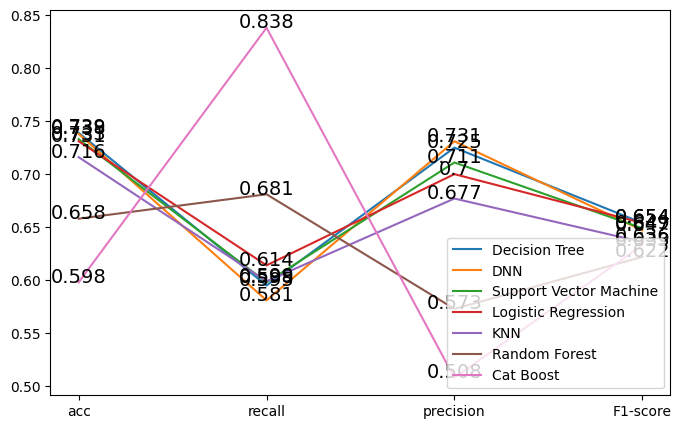

In [ ]:
pred_dnn = (dnn.predict(X_test) > 0.5).astype('int32')
pred_dnn = pred_dnn.reshape(1,-1)[0]
result_view('DNN', pred_dnn, y_test)

#AI 모델 평가하기

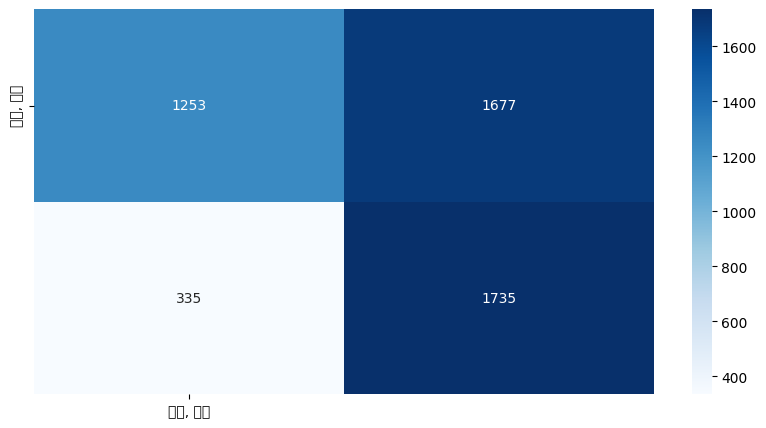

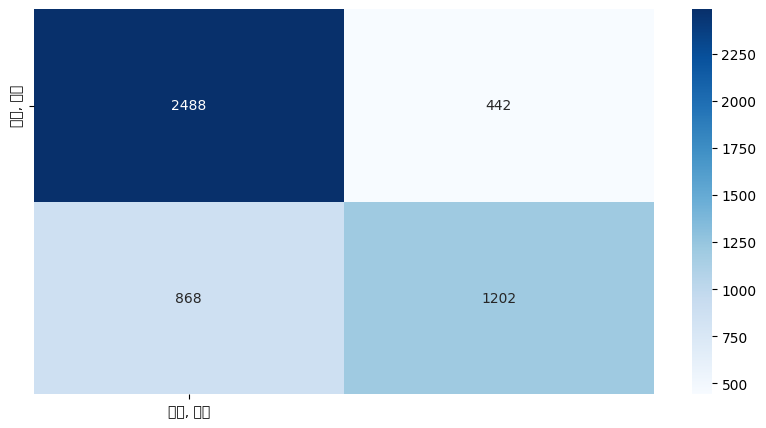

(None, None)

In [ ]:
def show_confusion_matrix(labels, y_true, y_pred, title):
  plt.rcParams['figure.figsize'] = (10,5)
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=labels, yticklabels=labels,
              cmap=plt.cm.Blues, linecolor='black')
  plt.show()

labels = ['해지, 유지']
show_confusion_matrix(labels, y_test, pred_cat, '[CatBoost]')
show_confusion_matrix(labels, y_test, pred_dnn, '[DNN]')


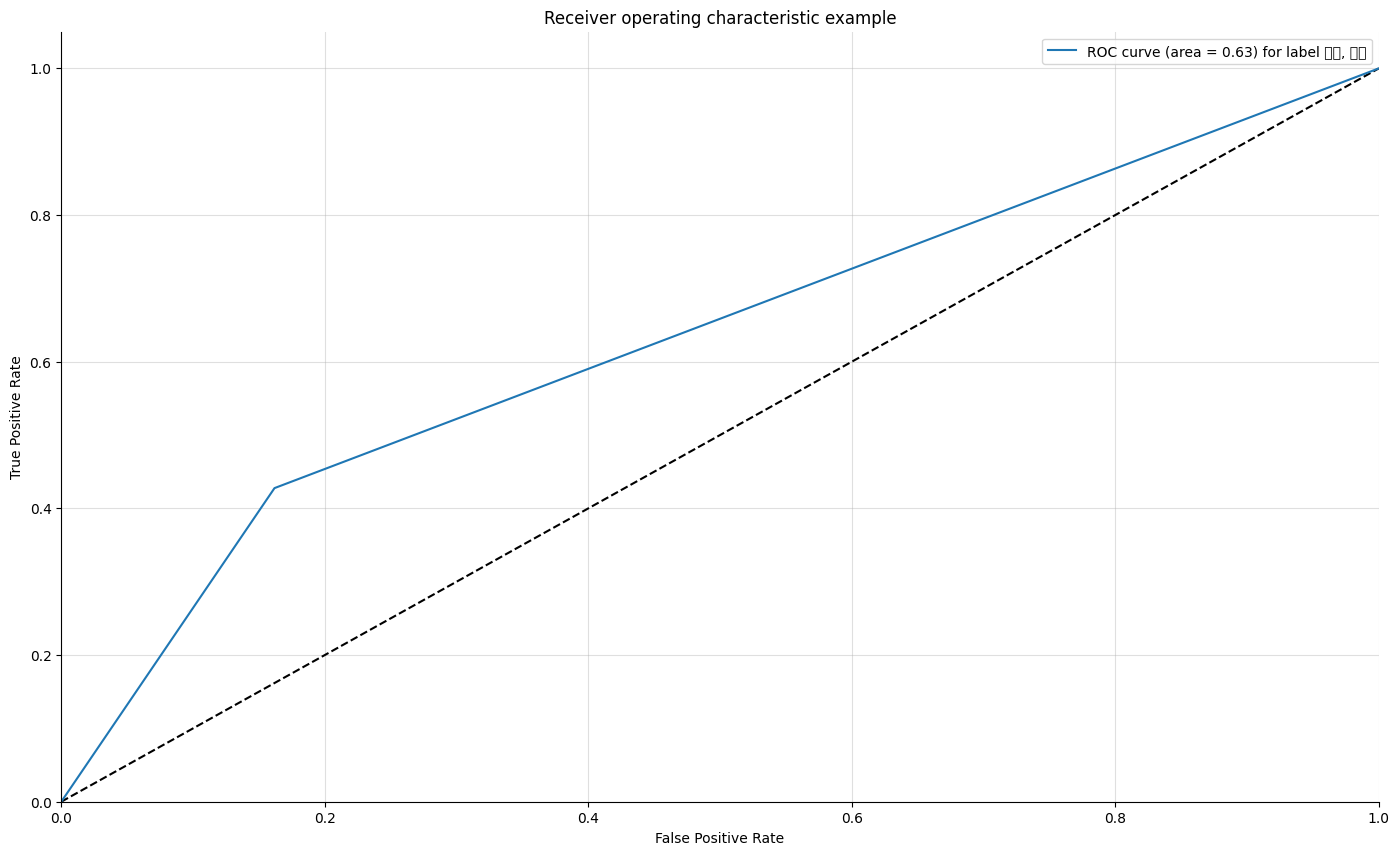

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(y_pred, y_true, y_label):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  y_test_dummies = pd.get_dummies(y_true, drop_first=False).values
  for i in range(len(y_label)):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  fig, ax = plt.subplots(figsize=(17,10))
  ax.plot([0,1], [0,1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic example')

  for i in range(len(y_label)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], y_label[i]))
  ax.legend(loc='best')
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

plot_multiclass_roc(pd.get_dummies(pred_cat).to_numpy(), y_test, labels)

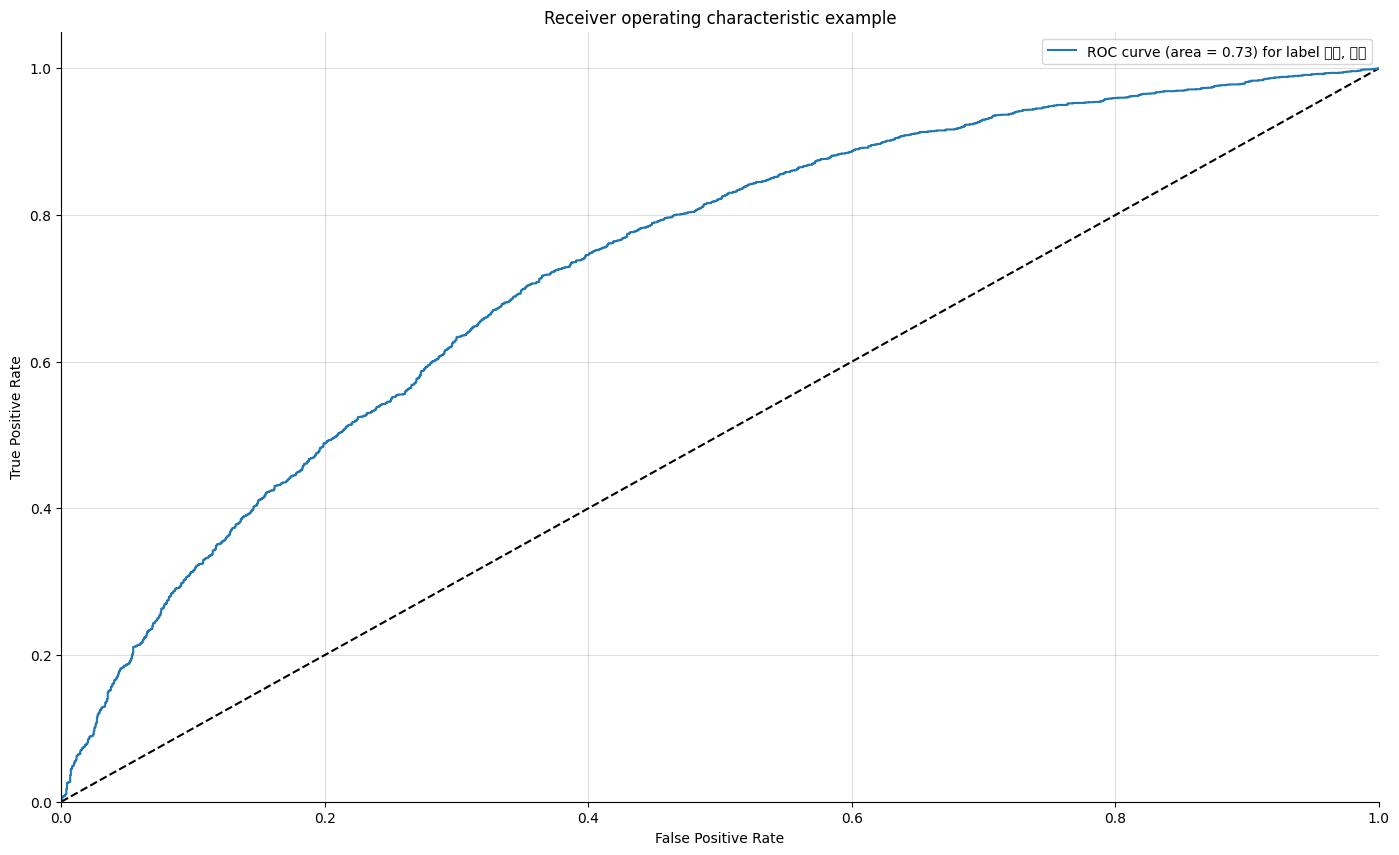

In [ ]:
pred_cat_proba = cat.predict_proba(X_test)
plot_multiclass_roc(pred_cat_proba, y_test, labels)